<a href="https://colab.research.google.com/github/erikaxenia/Data-Science-Acamica/blob/master/DS_SP_03_NLP_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Procesamiento de Lenguaje Natural
## Erika Xenia Angenello

# Tabla de Contenidos
1. [Introducción](#introduction)
2. [Análisis Exploratorio](#AnalisisExploratorio)
    1. [Exploración Inicial](#ExploracionInicial)
    2. [Distribución de las Reviews](#DistribuciondelasReviews)
    3. [Análisis de Sentimiento](#AnalisisdeSentimiento)
3. [Transformación de Datos](#TransformaciondeDatos)
4. [Modelo de Machine Learning](#ModelodeMachineLearning)
    1. [Iteración 1](#MMLIteración1)
    2. [Iteración 2](#MMLIteración2)
    3. [Iteración 3](#MMLIteración3)
5. [Investigación](#Investigacion)
6. [Conclusión](#Conclusion)

# 1. Introducción <a name="introduction"></a>

El objetivo final de este proyecto será desarrollar un modelo que prediga la cantidad de estrellas con las que se calificará a un producto a partir de la crítica escrita en la reseña por el usuario. 

Para realizar dicho trabajo, utilizaremos una colección de reseñas en español de Amazon diseñadas específicamente para ayudar a la investigación en la clasificación de textos. 

Las variables que tenemos en nuestro set de datos responden a la siguiente información:

* **review_id** - Id de reseña
* **product_id** - Id del producto
* **reviewer_id** - Id de reseña
* **stars** - Cantidad de Estrellas con la que fue puntuada el producto
* **review_body** - Cuerpo de la reseña
* **review_title** - Título de la reseña
* **language** - Idioma de la reseña
* **product_category** - Categoría del producto

# 2. Análisis Exploratorio <a name="AnalisisExploratorio"></a>

## 2.1 Exploración Inicial <a name="ExploracionInicial"></a>

A continuación, realizaremos la exploración inicial de nuestro conjunto de datos. 

In [ ]:
# Importo las librerías principales para trabajar
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from google.colab import drive
import itertools

#Doy formato a la visualización del dataframe
pd.options.display.float_format = '{:,.1f}'.format

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#data = pd.read_json(r'C:\Users\Erika\Desktop\ACÁMICA\SPRINT 3\Sprint Proyect 3\Procesamiento de Lenguaje Natural\dataset_es_train.json', lines= True)
data = pd.read_json("/content/drive/MyDrive/Colab Notebooks/CNN/Data/dataset_es_train.json", lines= True)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [ ]:
data.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
199995,es_0715276,product_es_0317036,reviewer_es_0643604,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,es,electronics
199996,es_0085190,product_es_0622919,reviewer_es_0466173,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,es,electronics
199997,es_0484496,product_es_0358101,reviewer_es_0330744,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,es,apparel
199998,es_0930141,product_es_0788855,reviewer_es_0694290,5,Perfecto para el cumple de mi hijo,Recomendado,es,toy
199999,es_0859809,product_es_0378794,reviewer_es_0141717,5,"Súper bien! Las brochas son buenas, no sé meno...",Preciosas,es,home


In [ ]:
data.shape

(200000, 8)

In [ ]:
# Observo los tipos de tados por variable
data.dtypes

review_id           object
product_id          object
reviewer_id         object
stars                int64
review_body         object
review_title        object
language            object
product_category    object
dtype: object

In [ ]:
# Calculo los estadísticos principales (sólo tenemos una variable numérica)
data.describe()

,stars
count,"200,000.0"
mean,3.0
std,1.4
min,1.0
25%,2.0
50%,3.0
75%,4.0
max,5.0


In [ ]:
# CALCULO MISSING

a = data[['review_body','review_title', 'product_category', 'stars']].isnull().sum(axis=0)
b = round(a/data.shape[0]*100,2)

missing_df = pd.DataFrame({'missing_totales' : a, 'missing_freq' : b})

missing_df[missing_df['missing_totales']>0]

,missing_totales,missing_freq


Nuestro dataset no presenta valores missing.

## 2.2 Distribución de las Reviews <a name="DistribuciondelasReviews"></a>

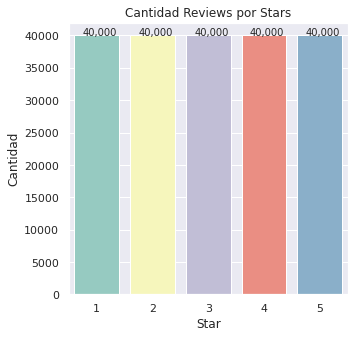

In [ ]:
plt.rc("figure", figsize=(5, 5))

# Grafico
ax = sns.countplot(data = data, x = 'stars', orient="v", palette ='Set3')

plt.title('Cantidad Reviews por Stars')
plt.xlabel('Star')
plt.ylabel('Cantidad')


for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
#ax.yaxis.set_ticks(np.linspace(0, len_star, 10))

plt.show()

Con el presente gráfico podemos observar que cada una de nuestra clases se encuentran balanceadas, presentando 40 mil instancias por cantidad de estrellas.

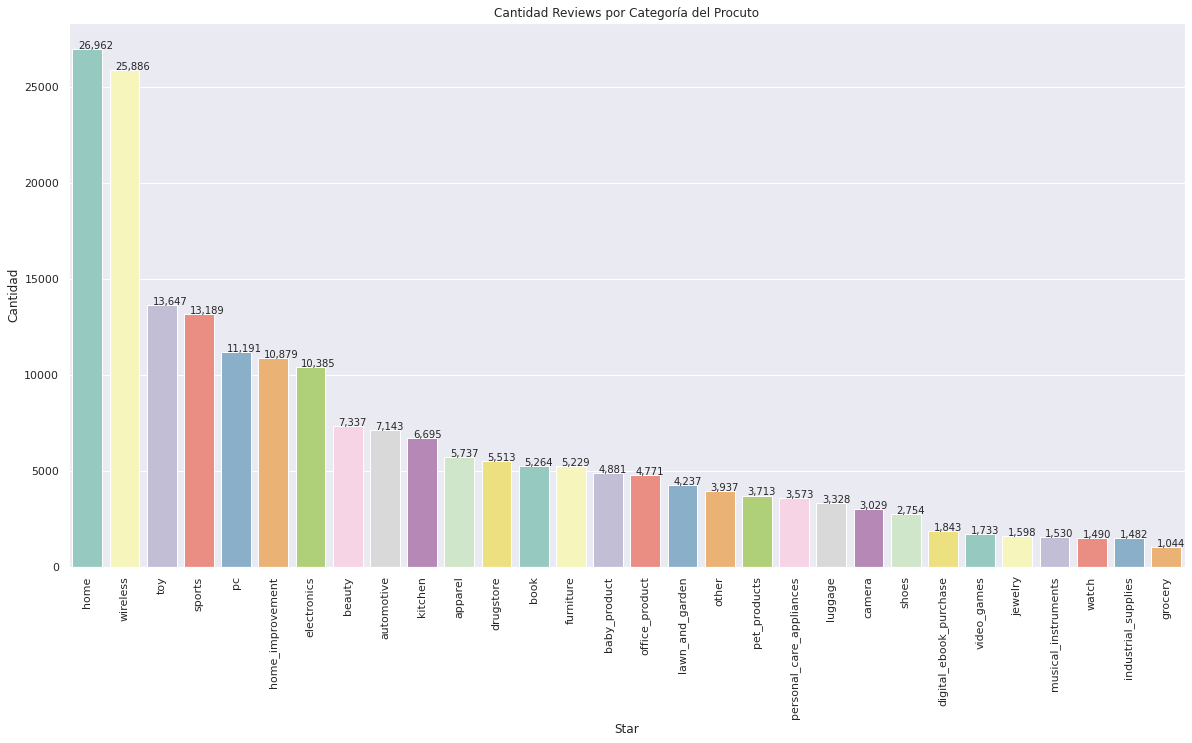

In [ ]:
plt.rc("figure", figsize=(20, 10))

# Grafico
ax = sns.countplot(data = data, x = 'product_category', order= data['product_category'].value_counts().index, orient="v", palette ='Set3')
plt.setp(ax.get_xticklabels(), rotation=90)

plt.title('Cantidad Reviews por Categoría del Procuto')
plt.xlabel('Star')
plt.ylabel('Cantidad')


for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
plt.show()

In [ ]:
#Preparo los datos

N_TOP = 10

# Preparo los datos para graficar

count = data.groupby(['stars','product_category'], as_index=False)['language'].count()
count_max = count.sort_values(['stars', 'language'], ascending=False).groupby('stars').head(N_TOP)

# Renombro
count_max = count_max.rename(columns = {'language': 'Total'}, inplace = False)

# Joineo con la data original para quedarme sólo con los barrios que están en el top
data_grap = data.merge(count_max, how='left', on=['stars','product_category'])

#Reemplazo nuelos por 0
data_grap = data_grap.fillna(0)

# Reemplazo por OTROS para graficar
data_grap['product_category']= np.where(data_grap['Total'] == 0,'OTROS', data_grap['product_category'])



In [ ]:
data_grap.head(2)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,Total
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics,"2,402.0"
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics,"2,402.0"


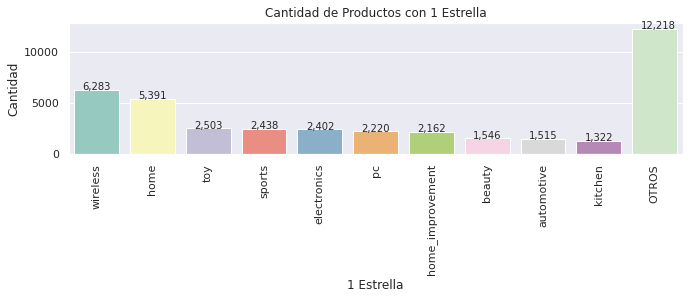

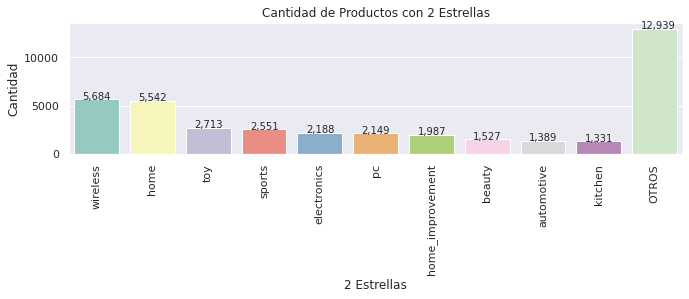

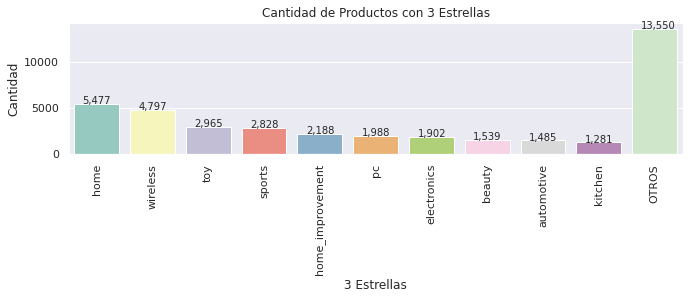

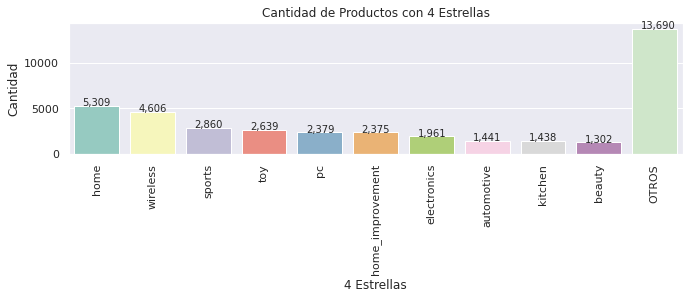

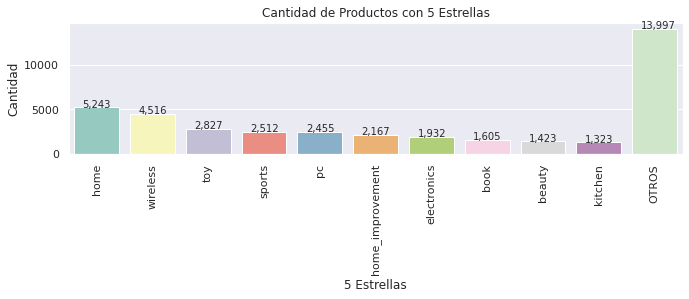

In [ ]:
# Grafico

# 1 ESTRELLA #######################################
plt.figure(figsize=(11,14))
plt.subplot(5, 1, 1)

g1 = sns.countplot(data = data_grap[data_grap['stars']==1], x='product_category', 
                   order = data_grap[data_grap['stars']==1]['product_category'].value_counts().index.drop('OTROS').insert(N_TOP+1, 'OTROS'), 
                   orient="v", palette ='Set3')
plt.setp(g1.get_xticklabels(), rotation=90)

plt.title('Cantidad de Productos con 1 Estrella')
plt.xlabel('1 Estrella')
plt.ylabel('Cantidad')

for p in g1.patches:
    g1.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

# 2 ESTRELLAS #######################################
plt.figure(figsize=(11,14))
plt.subplot(5, 1, 2)

g2 = sns.countplot(data = data_grap[data_grap['stars']==2], x='product_category', 
                   order = data_grap[data_grap['stars']==2]['product_category'].value_counts().index.drop('OTROS').insert(N_TOP+1, 'OTROS'), 
                   orient="v", palette ='Set3')
plt.setp(g2.get_xticklabels(), rotation=90)

plt.title('Cantidad de Productos con 2 Estrellas')
plt.xlabel('2 Estrellas')
plt.ylabel('Cantidad')

for p in g2.patches:
    g2.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
# 3 ESTRELLAS #######################################
plt.figure(figsize=(11,14))
plt.subplot(5, 1, 3)

g3 = sns.countplot(data = data_grap[data_grap['stars']==3], x='product_category', 
                   order = data_grap[data_grap['stars']==3]['product_category'].value_counts().index.drop('OTROS').insert(N_TOP+1, 'OTROS'), 
                   orient="v", palette ='Set3')
plt.setp(g3.get_xticklabels(), rotation=90)

plt.title('Cantidad de Productos con 3 Estrellas')
plt.xlabel('3 Estrellas')
plt.ylabel('Cantidad')

for p in g3.patches:
    g3.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
    
# 4 ESTRELLAS #######################################
plt.figure(figsize=(11,14))
plt.subplot(5, 1, 4)

g4 = sns.countplot(data = data_grap[data_grap['stars']==4], x='product_category', 
                   order = data_grap[data_grap['stars']==4]['product_category'].value_counts().index.drop('OTROS').insert(N_TOP+1, 'OTROS'), 
                   orient="v", palette ='Set3')
plt.setp(g4.get_xticklabels(), rotation=90)

plt.title('Cantidad de Productos con 4 Estrellas')
plt.xlabel('4 Estrellas')
plt.ylabel('Cantidad')

for p in g4.patches:
    g4.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

# 5 ESTRELLAS #######################################
plt.figure(figsize=(11,14))
plt.subplot(5, 1, 5)

g5 = sns.countplot(data = data_grap[data_grap['stars']==5], x='product_category', 
                   order = data_grap[data_grap['stars']==5]['product_category'].value_counts().index.drop('OTROS').insert(N_TOP+1, 'OTROS'), 
                   orient="v", palette ='Set3')
plt.setp(g5.get_xticklabels(), rotation=90)

plt.title('Cantidad de Productos con 5 Estrellas')
plt.xlabel('5 Estrellas')
plt.ylabel('Cantidad')

for p in g5.patches:
    g5.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
#plt.savefig('snscounter.pdf')

Los gráicos nos muestran que los tipos de productos se distribuyen casi uniformemente en cada una de las clases a predecir, presentando en todos los casos las mismas 10 principales categorias por estrella.

* Home
* Wireless
* Toy
* Sports
* PC
* Home Improvement
* Electronics
* Book
* Beauty
* Kitchen

**CONSIDERACIONES**

De nuestro dataset original, únicamente utilizaremos las variables de `review_body`, `review_title` y `star` ya que son las únicas que nos aportan información para la predicción.

Originalmente se consideró que la variable `product_category` podría brindarnos información para nuestro problema, al comprobar que la cantidad de instancias por tipos de productos está uniformemente distribuido en cada una de las estrellas, entendemos que no podremos extraer un diferencial de dicha variable. Posiblemente esto suceda porque estamos utilizando un dataset para fines académicos cuyas muestras fueron seleccionadas con esta distribución intencionalmente. 

Finalmente, el tipo de problema que estamos abordando no requiere de las transformaciones clásicas de datos tales como:
* Detección y eliminación de outliers
* Encoding
* Imnputación de valores faltantes
* Escalado de datos
* Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

Sin embargo, en un apartado posterior se realizarán las transformaciones encesarias para convertir nuestra variable alfanumérica en numérica y así poder ser consumible por los modelos de machine learning a aplicar.

#### Nuevas Variables:
A continuación se crearán las siguientes variables:
* `star_calif`: La cuál tomará valor de 0 (Negativo) si la variable `star` es menor o igual a 3 estrellas y 1 (Positivo) si es mayor.
* `review_all`: La misma concatenará la información provistar por las variables `review_title` y `review_body`

In [ ]:
# Creamos la variable stars_calif para análisis de sentimiento
data['stars_calif'] = [1 if data['stars'][i]> 3 else 0 for i in data.index]

In [ ]:
# Creo la variable 'review_all', que es una concatenación de 'review_title' y 'review_body'
data['review_all']=[(str(data['review_title'][i])+" "+str(data['review_body'][i])) for i in data.index]

In [ ]:
data['review_all'][5]

'Jamás me llegó Jamás me llegó y el vendedor nunca contacto conmigo a pesar de intentarlo 2 veces'

#### Submuestreo de Clases:
Para todo el trabajo que se presentará a continuación, la capacidad de procesamiento local con la que se cuenta y la provista por Colab, son insuficientes para poder procesar el dataset de train completo con sus 200 mil instancias. Cabe aclarar al respecto, que se han agotado los intentos por procesar el dataset completo y en todos los casos por tiempos de ejecución o límite de la memoria ram, colab ha interrumpido el trabajo e iniciado a cero la ejecución.

Es por lo expuesto que se ha decido realizar un submuestreo incial de 5 mil instancias por clase.

In [ ]:
# Submuestro y balanceo de clases
data_sample = data.groupby('stars')
data_sample = pd.DataFrame(data_sample.apply(lambda x: x.sample(data_sample.size().min()-35000).reset_index(drop=True))).reset_index(drop=True)

In [ ]:
#data_sample.to_excel('data_sample.xlsx')
#data_train = pd.read_excel('data_sample.xlsx')

In [ ]:
data_train = data_sample.copy()

In [ ]:
data_train.shape

(25000, 10)

In [ ]:
data_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,stars_calif,review_all
0,es_0670397,product_es_0135485,reviewer_es_0016720,1,Mando mediocre y muy mala calidad,Malo,es,video_games,0,Malo Mando mediocre y muy mala calidad
1,es_0979147,product_es_0080420,reviewer_es_0640718,1,La descripción del producto y la foto no se co...,Pésimo,es,wireless,0,Pésimo La descripción del producto y la foto n...
2,es_0453228,product_es_0883697,reviewer_es_0752459,1,"Es un engaño, pagas casi cinco euros por un cu...",Un timo,es,toy,0,"Un timo Es un engaño, pagas casi cinco euros p..."
3,es_0215870,product_es_0706210,reviewer_es_0369173,1,No tiene nada que ver con el original de hace ...,No cumple las expectativas,es,beauty,0,No cumple las expectativas No tiene nada que v...
4,es_0893310,product_es_0717695,reviewer_es_0125810,1,Se suelta la palanca del pedal de la tapa. El ...,El mecanismo de apertura del pedal se estropea...,es,home,0,El mecanismo de apertura del pedal se estropea...


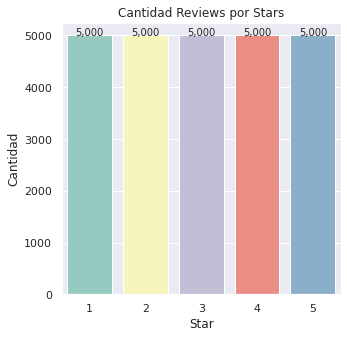

In [ ]:
plt.rc("figure", figsize=(5, 5))

# Grafico

ax = sns.countplot(data = data_train, x = 'stars', orient="v", palette ='Set3')

plt.title('Cantidad Reviews por Stars')
plt.xlabel('Star')
plt.ylabel('Cantidad')


for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

plt.show()

## 2.3 Análisis de Sentimiento <a name="AnalisisdeSentimiento"></a>

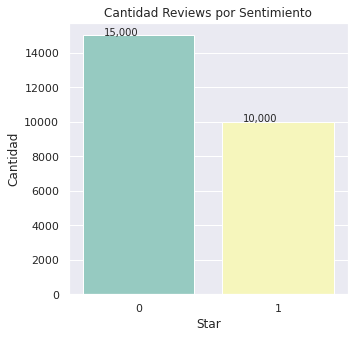

In [ ]:
plt.rc("figure", figsize=(5, 5))

# Grafico

ax = sns.countplot(data = data_train, x = 'stars_calif', orient="v", palette ='Set3')

plt.title('Cantidad Reviews por Sentimiento')
plt.xlabel('Star')
plt.ylabel('Cantidad')


for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
plt.show()

### Normalización

In [ ]:
#!python -m spacy download es_core_news_md

In [ ]:
import spacy
#import es_core_news_sm
import es_core_news_md
from spacy.lang.es.stop_words import STOP_WORDS

import nltk
from nltk import Tree
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS
import string
from collections import Counter
import unicodedata
import re
import itertools

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

nlp = es_core_news_md.load()
tokenizer = ToktokTokenizer()
stopword_list=  nltk.corpus.stopwords.words('spanish')
stopwords = spacy.lang.es.stop_words.STOP_WORDS
punct = string.punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### SpaCy Features 

A continuación, se explorarán las siguientes funciones de Spacy:

NAME |	DESCRIPTION |
:----- |:------|
Tokenization|Segmentar el texto en palabras, signos de puntuación, etc.|
Part-of-speech (POS) Tagging|	Asignar tipos de palabras a tokens, como verbo o sustantivo.|
Dependency Parsing|	Asignar etiquetas de dependencia sintáctica, describiendo las relaciones entre tokens individuales, como sujeto u objeto.|
Lemmatization|Asignar las formas base de las palabras. Por ejemplo, el lema de "era" es "ser" y el lema de "ratas" es "rata".|
Similarity|	Comparar palabras, tramos de texto y documentos y qué tan similares son entre sí.|


FUENTE: https://spacy.io/usage/spacy-101

In [ ]:
NLP_train = data_sample.copy()

NLP_train_some = NLP_train[['review_all']][0:10].copy()

In [ ]:
docex=nlp(NLP_train['review_all'][3])

# print column headers
print('{:15} | {:15} | {:8} | {:20} | {:11} | {:8} | {:8} | {:8} | '.format(
    'TEXT','LEMMA_','POS_','HEAD','DEP_','SHAPE_','IS_ALPHA','IS_STOP'))

# print various SpaCy POS attributes
for token in docex:
    print('{:15} | {:15} | {:8} | {:20} | {:11} | {:8} | {:8} | {:8} |'.format(
          token.text, token.lemma_, token.pos_, token.head.text, token.dep_
        , token.shape_, token.is_alpha, token.is_stop))

TEXT            | LEMMA_          | POS_     | HEAD                 | DEP_        | SHAPE_   | IS_ALPHA | IS_STOP  | 
No              | No              | ADV      | cumple               | advmod      | Xx       |        1 |        1 |
cumple          | cumplir         | VERB     | tiene                | csubj       | xxxx     |        1 |        0 |
las             | los             | DET      | expectativas         | det         | xxx      |        1 |        1 |
expectativas    | expectativa     | NOUN     | cumple               | obj         | xxxx     |        1 |        0 |
No              | No              | ADV      | tiene                | advmod      | Xx       |        1 |        1 |
tiene           | tener           | VERB     | tiene                | ROOT        | xxxx     |        1 |        1 |
nada            | nadar           | PRON     | tiene                | obj         | xxxx     |        1 |        1 |
que             | que             | AUX      | tiene           

In [ ]:
# Similaridad de Coseno entre reviews
docex_1=nlp(NLP_train['review_all'][0])
docex_2=nlp(NLP_train['review_all'][1])

print(docex_1)
print(docex_2)
print(docex_1.similarity(docex_2))

Malo Mando mediocre y muy mala calidad
Pésimo La descripción del producto y la foto no se corresponde con el producto que me enviaron. El protector que me envían tiene un hueco abierto para el botón central y otro para el altavoz y la cámara, por lo que por esas zonas el móvil no está protegido. También indican que viene con una toallita limpiadora y no es así. He solicitado la devolución.
0.9327675422870058


In [ ]:
# Similaridad de Coseno entre tokens
token1 = docex_1[0]
token2 = docex_2[0]

print(token1)
print(token2)
print(token1.similarity(token2))

Malo
Pésimo
0.66452616


In [ ]:
# Gráfico de dependencias de una reviw
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

[to_nltk_tree(sent.root).pretty_print() for sent in docex.sents]

                                                               tiene                                                        
  _______________________________________________________________|________________________________________________           
 |   |    |   |        |                                             original                                     |         
 |   |    |   |        |                   _____________________________|___________                              |          
 |   |    |   |      cumple               |   |       |                           aroma                         igual       
 |   |    |   |    ____|_________         |   |       |           __________________|_________                ____|_____     
 |   |    |   |   |         expectativas  |   |      años        |      |      |    |       tacto            |    |   envase
 |   |    |   |   |              |        |   |    ___|____      |      |      |    |     ____|_________     |    |     | 

[None]

In [ ]:
# Vector con Word2Vec
print(token2.vector)

[-0.83076  -0.33823  -0.557027 -0.488584 -0.325602 -1.242383 -0.274634
  0.398406 -0.170383  0.975635 -0.513835  0.12436  -0.05272  -0.08128
 -0.121118  0.215884  0.418427  0.34099   1.381153  0.456982  1.112232
  0.005404 -0.76245  -0.083885  0.112485 -0.562361 -0.759773  0.377274
  0.48802   0.315464  1.030169  0.669262 -0.552661 -0.018498  0.10154
  1.274372 -0.149195  0.231536 -0.015494  0.30715  -0.682697  0.820377
 -0.669936 -0.682598  0.457715 -0.879825 -0.24133  -1.296276 -0.281796
  0.966792]


In [ ]:
tokens = []
lemma = []
pos = []

for doc in nlp.pipe(NLP_train_some['review_all'].astype('unicode').values, batch_size=50):
    if doc.is_parsed:
        # Token
        tokens.append([n.text for n in doc])
        # Token lematizado y en minúscula
        lemma.append([n.lemma_.lower() for n in doc])
        # Part of speach
        pos.append([n.pos_ for n in doc])
    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)

NLP_train_some['review_tokens'] = tokens
NLP_train_some['review_lemma'] = lemma
NLP_train_some['review_pos'] = pos

In [ ]:
NLP_train_some

,review_all,review_tokens,review_lemma,review_pos
0,Malo Mando mediocre y muy mala calidad,"[Malo, Mando, mediocre, y, muy, mala, calidad]","[malo, mando, mediocre, y, muy, malo, calidad]","[ADJ, PROPN, ADJ, CONJ, ADV, ADJ, NOUN]"
1,Pésimo La descripción del producto y la foto n...,"[Pésimo, La, descripción, del, producto, y, la...","[pésimo, la, descripción, del, producto, y, lo...","[ADJ, DET, NOUN, ADP, NOUN, CONJ, DET, NOUN, A..."
2,"Un timo Es un engaño, pagas casi cinco euros p...","[Un, timo, Es, un, engaño, ,, pagas, casi, cin...","[un, timar, es, uno, engañar, ,, pagar, casi, ...","[DET, ADJ, AUX, DET, NOUN, PUNCT, VERB, ADV, N..."
3,No cumple las expectativas No tiene nada que v...,"[No, cumple, las, expectativas, No, tiene, nad...","[no, cumplir, los, expectativa, no, tener, nad...","[ADV, VERB, DET, NOUN, ADV, VERB, PRON, AUX, V..."
4,El mecanismo de apertura del pedal se estropea...,"[El, mecanismo, de, apertura, del, pedal, se, ...","[el, mecanismo, de, apertura, del, pedal, se, ...","[DET, NOUN, ADP, NOUN, ADP, NOUN, PRON, VERB, ..."
5,Se demoró demasiado Tardaron más de 1 mes resp...,"[Se, demoró, demasiado, Tardaron, más, de, 1, ...","[se, demorar, demasiar, tardaron, más, de, 1, ...","[PRON, VERB, ADV, VERB, ADV, ADP, NUM, NOUN, N..."
6,"Falta material Diferentes tamaños, colores rep...","[Falta, material, Diferentes, tamaños, ,, colo...","[falta, material, diferentes, tamaño, ,, color...","[VERB, NOUN, DET, NOUN, PUNCT, NOUN, ADJ, PUNC..."
7,"Mal embalaje,no llegan bien Que desilusión uno...","[Mal, embalaje, ,, no, llegan, bien, Que, desi...","[mal, embalaje, ,, no, llegar, bien, que, desi...","[ADJ, NOUN, PUNCT, ADV, VERB, ADV, SCONJ, VERB..."
8,Fraude El paquete estaba ya abierto de malas m...,"[Fraude, El, paquete, estaba, ya, abierto, de,...","[fraude, el, paquete, estar, ya, abrir, de, ma...","[PROPN, DET, NOUN, AUX, ADV, ADJ, ADP, ADJ, NO..."
9,La impresora viene sin cartuchos Compré esta i...,"[La, impresora, viene, sin, cartuchos, Compré,...","[la, impresor, venir, sin, cartucho, compré, e...","[DET, NOUN, VERB, ADP, NOUN, VERB, DET, NOUN, ..."


## Función de Normalización de texto:
En dicha función, realizaremos el siguiente proceso:
* Se tokenizarán las reviws. La unidad semántica elegida para la tokenización serán palabras.
* Se eliminarán las palabras de menos de 2 caracteres.
* Aplicaremos Lematización, en donde agruparemos a las palabras por su raíz y el rol que cumple en el texto.
* Eliminaremos las palabras que el lematizador identifique como Pronombre.
* Llevaremos todas las palabras a minúscula.
* Eliminaremos las palabras que no transmiten información (Stopwords).
* Aplicaremos Expresiones Regulares (Regex) para eliminar cualquier patrón en el texto que no nos aporte información.


In [ ]:
stopwords.remove('no')

In [ ]:
def dataCleaning(sentence):
    doc = nlp(sentence)
    tokens = []
    for token in doc:
        if len(token)>1: #si el token tiene más de 1 caracter
            # Forma base del token, sin sufijos de flexión. Y lo pasamos a minuscula.
            if token.lemma_ != '-PRON-':
              temp = token.lemma_.lower()
              tokens.append(temp)
              clean_tokens = []
              # Quitamos stopswords
              for token in tokens:
                  #if token not in punct and token not in stopwords:
                  if token not in stopwords:
                      clean_tokens.append(token)
    return clean_tokens

def remove_accented_chars(text):
    # Removemos los caracteres especiales
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Eliminamos cualquier caracter que no sen los siguientes: a-z A-Z 0-9   
    pattern = r'[^a-zA-Z0-9\s]' 
    text = re.sub(pattern, '', text)
     
    return text

Aplicamos nuestra función de normalización al texto

In [ ]:
titular_list_clean=[]

i=0
titular_clean=[]
for titular in NLP_train['review_all']:
    titular=remove_accented_chars(str(titular))
    titular_clean=dataCleaning(titular)
    titular_list_clean.append(titular_clean)
    i=+1

In [ ]:
#NLP_train['Review_Cleaning'] = titular_list_clean
data_train['Review_Cleaning'] = titular_list_clean

In [ ]:
data_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,stars_calif,review_all,Review_Cleaning
0,es_0670397,product_es_0135485,reviewer_es_0016720,1,Mando mediocre y muy mala calidad,Malo,es,video_games,0,Malo Mando mediocre y muy mala calidad,"[malo, mando, mediocre, malo, calidad]"
1,es_0979147,product_es_0080420,reviewer_es_0640718,1,La descripción del producto y la foto no se co...,Pésimo,es,wireless,0,Pésimo La descripción del producto y la foto n...,"[pesimo, descripcion, producto, foto, no, corr..."
2,es_0453228,product_es_0883697,reviewer_es_0752459,1,"Es un engaño, pagas casi cinco euros por un cu...",Un timo,es,toy,0,"Un timo Es un engaño, pagas casi cinco euros p...","[timar, engano, pagar, cincar, euro, cuaderno,..."
3,es_0215870,product_es_0706210,reviewer_es_0369173,1,No tiene nada que ver con el original de hace ...,No cumple las expectativas,es,beauty,0,No cumple las expectativas No tiene nada que v...,"[no, cumplir, expectativa, no, nadar, original..."
4,es_0893310,product_es_0717695,reviewer_es_0125810,1,Se suelta la palanca del pedal de la tapa. El ...,El mecanismo de apertura del pedal se estropea...,es,home,0,El mecanismo de apertura del pedal se estropea...,"[mecanismo, apertura, pedal, estropear, suelto..."


A continuación, separaremos las reviews con sentimiento negativo de las de sentimiento positivo para su posterior análisi gráfico.

In [ ]:
data_review_positivos = data_train[data_train['stars_calif']==1]
review_positivos = data_review_positivos['Review_Cleaning'].copy()
review_positivos.head(2)

15000    [jesus, figurar, no, detallar, comer, imagenes...
15001    [bombilla, parir, mejorar, control, luz, movil...
Name: Review_Cleaning, dtype: object

In [ ]:
data_review_negativos = data_train[data_train['stars_calif']==0]
review_negativos = data_review_negativos['Review_Cleaning'].copy()
review_negativos.head(2)

0               [malo, mando, mediocre, malo, calidad]
1    [pesimo, descripcion, producto, foto, no, corr...
Name: Review_Cleaning, dtype: object

In [ ]:
todos_titulares_palabras_pos = list(itertools.chain(*review_positivos))
todos_titulares_palabras_neg = list(itertools.chain(*review_negativos))

In [ ]:
count_pos=Counter(todos_titulares_palabras_pos)
count_neg=Counter(todos_titulares_palabras_neg)

bigrams_series_pos = (pd.Series(nltk.ngrams(todos_titulares_palabras_pos, 2)).value_counts())[:20]
trigrams_series_pos = (pd.Series(nltk.ngrams(todos_titulares_palabras_pos, 3)).value_counts())[:20]
bigrams_series_neg = (pd.Series(nltk.ngrams(todos_titulares_palabras_neg, 2)).value_counts())[:20]
trigrams_series_neg = (pd.Series(nltk.ngrams(todos_titulares_palabras_neg, 3)).value_counts())[:20]

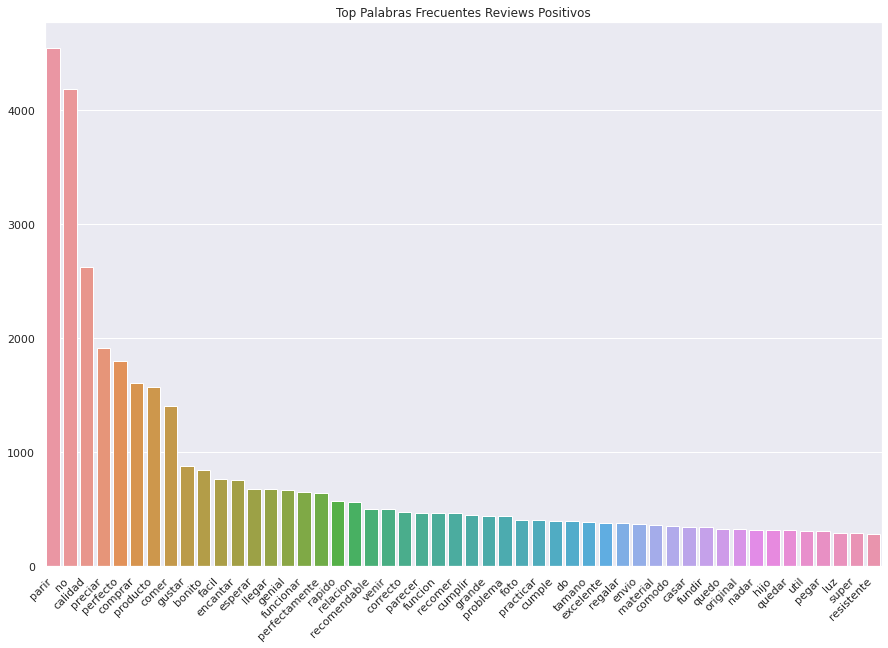

In [ ]:
# Plot top 50 most frequently
common_words = [word[0] for word in count_pos.most_common(50)]
common_counts = [word[1] for word in count_pos.most_common(50)]
#plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=common_words, y=common_counts, ax=ax)
plt.title('Top Palabras Frecuentes Reviews Positivos')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

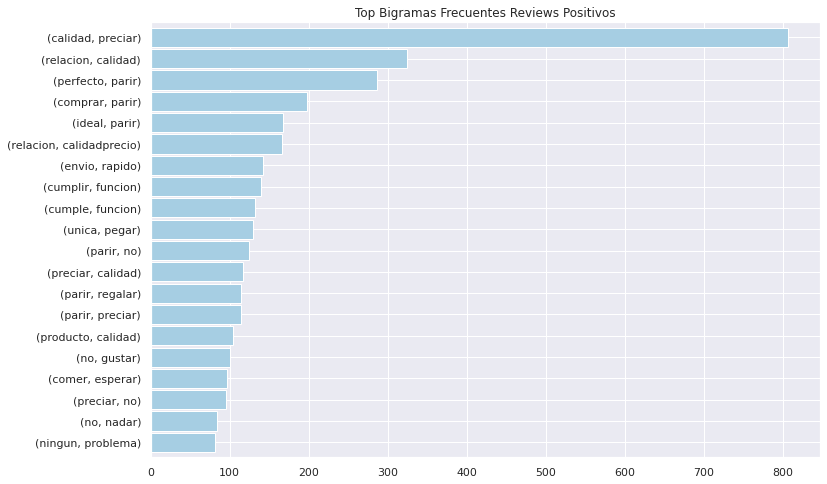

In [ ]:
bigrams_series_pos.sort_values().plot.barh(width=.9, colormap='Paired', figsize=(12, 8))
plt.title('Top Bigramas Frecuentes Reviews Positivos')

plt.show()

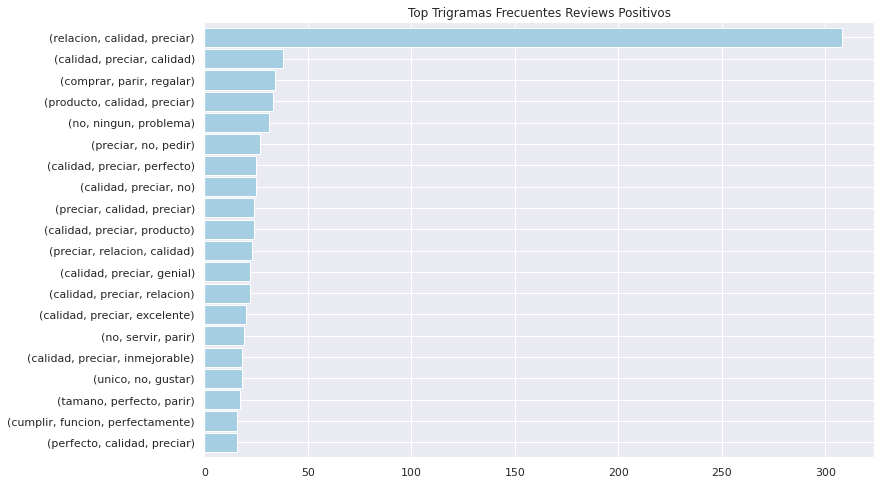

In [ ]:
trigrams_series_pos.sort_values().plot.barh(width=.9, colormap='Paired',  figsize=(12, 8))
plt.title('Top Trigramas Frecuentes Reviews Positivos')

plt.show()

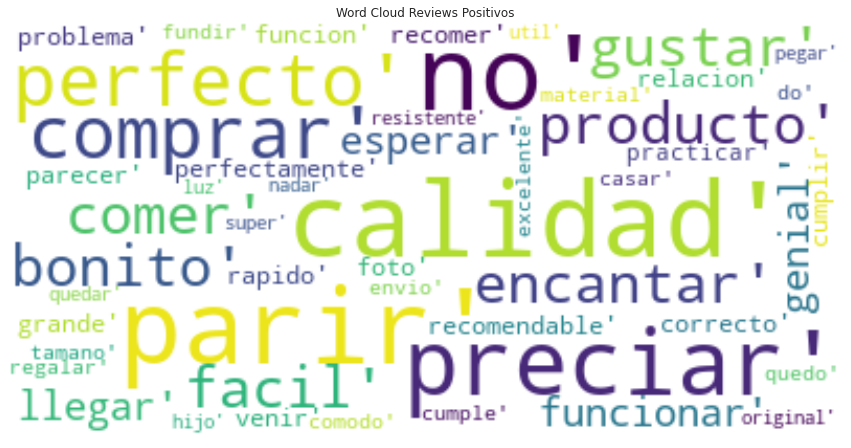

In [ ]:
plt.rc("figure", figsize=(15, 15))

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(common_words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud Reviews Positivos')
plt.axis("off")
plt.show()

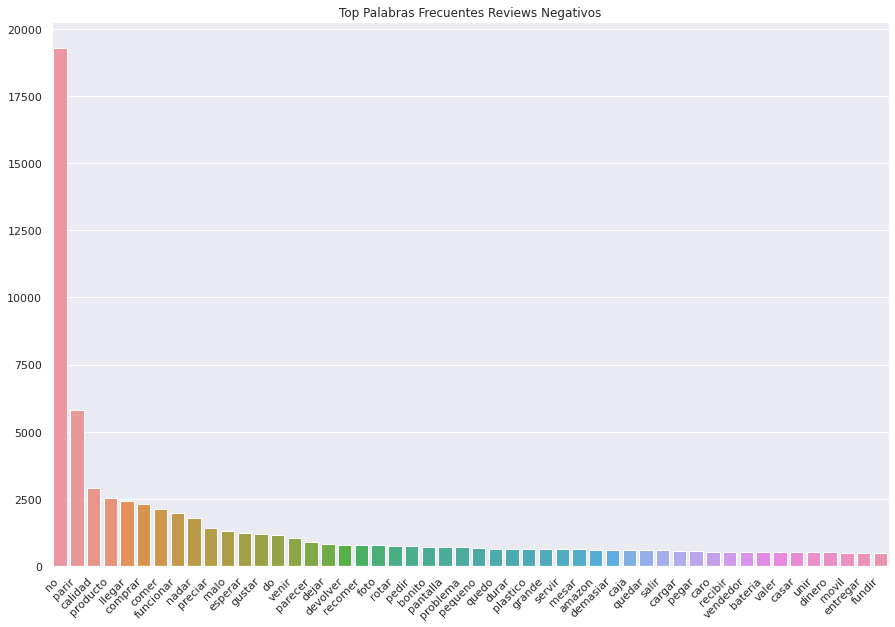

In [ ]:
# Plot top 50 most frequently
common_words = [word[0] for word in count_neg.most_common(50)]
common_counts = [word[1] for word in count_neg.most_common(50)]
#plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=common_words, y=common_counts, ax=ax)
plt.title('Top Palabras Frecuentes Reviews Negativos')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

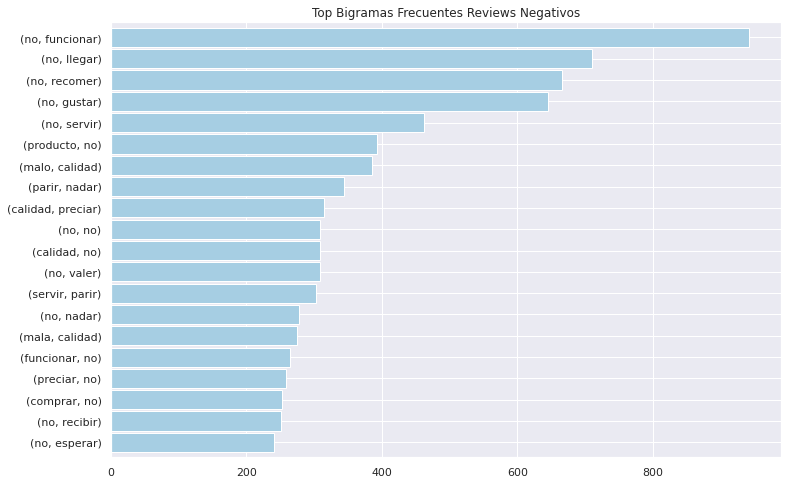

In [ ]:
bigrams_series_neg.sort_values().plot.barh(width=.9, colormap='Paired', figsize=(12, 8))
plt.title('Top Bigramas Frecuentes Reviews Negativos')

plt.show()

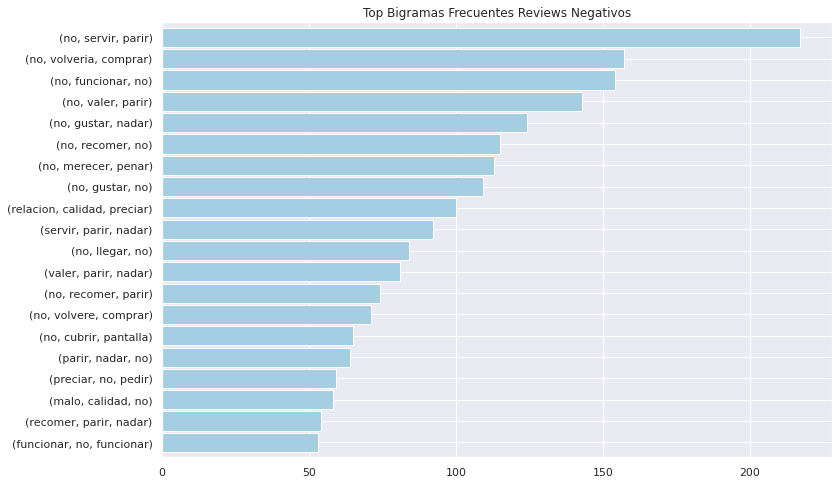

In [ ]:
trigrams_series_neg.sort_values().plot.barh(width=.9, colormap='Paired', figsize=(12, 8))
plt.title('Top Bigramas Frecuentes Reviews Negativos')

plt.show()

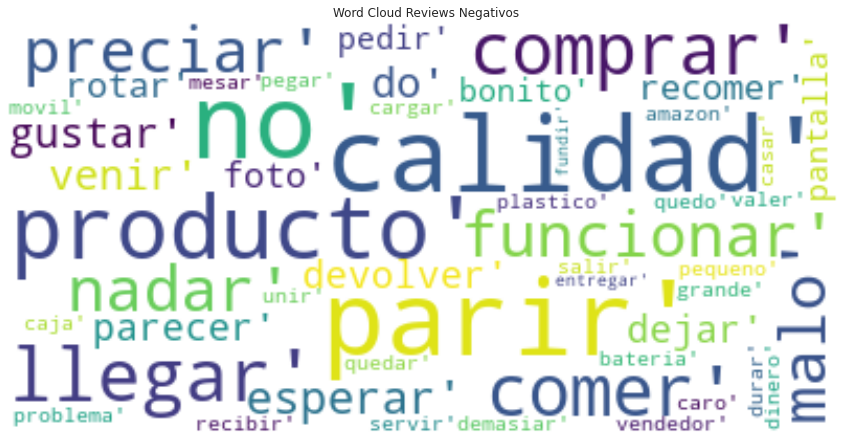

In [ ]:
plt.rc("figure", figsize=(15, 15))

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(common_words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud Reviews Negativos')
plt.axis("off")
plt.show()

# 3. Transformación de Datos <a name="TransformaciondeDatos"></a>

Seguida de la Normalización de nuestro texto, debemos Vectorizarlo. Es decir, reemplazar a cada instancia por un vector de números que represente a cada uno de los tokens de dicha instancia.

En este apartado trabajaremos con dos tipos de vectorizaciones:
* **Count Vectorizer**: Convierte la columna de texto en una matriz en la que cada palabra es una columna cuyo valor es el número de veces que dicha palabra aparece en cada review.
* **TF-IDF: Term Frequency-Inverse Document Frequency**: Busca puntuaciones de frecuencia de palabras que tratan de resaltar las palabras que son más interesantes, por ejemplo, frecuentes en un documento pero no en todos los documentos. El TfidfVectorizer tokenizará documentos, aprenderá el vocabulario y las ponderaciones inversas de frecuencia de documentos. 

A continuación, probaremos optimizando el rendimiento de un posterior modelo modificando los valores de los parámetros de countvectorizer y tfidfvectorizer respectivamente. 


In [ ]:
titular_list_clean=[]

i=0
titular_clean=[]
for titular in data_train['review_all']:
    titular=remove_accented_chars(str(titular))
    titular_clean=dataCleaning(titular)
    titular_clean=' '.join(titular_clean)
    titular_list_clean.append(titular_clean)
    i=+1

In [ ]:
result = pd.Series(titular_list_clean)

In [ ]:
result

0                         malo mando mediocre malo calidad
1        pesimo descripcion producto foto no correspond...
2        timar engano pagar cincar euro cuaderno no lle...
3        no cumplir expectativa no nadar original ano a...
4        mecanismo apertura pedal estropear suelto pala...
                               ...                        
24995    calidadprecio calidad preciar envio rapido genial
24996                pendientes elegante unisex no calidad
24997    rapidez entregar color ilustracion esperar lav...
24998    cumple funcion cumple funcion no perder color ...
24999    producto tamano funcionar parecer resistente p...
Length: 25000, dtype: object

In [ ]:
len(result)

25000

In [ ]:
result.to_csv('result.csv', header=False)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

Parámetros de Count Vectorizer

In [ ]:
max_features = [100,200,300,500,700,1000,1300,1500] #No se prueban más features porque agota toda la memoria ram de colab
labels = [1, 2, 3, 4, 5]
training_auc = [] 
testing_auc = []


for max_feature in max_features:
    # Vectorizo con count vectorizer
    cvectorizer = CountVectorizer(lowercase=True, strip_accents='unicode', decode_error='ignore', max_features=max_feature)
    matriz_titulos_count_vectorizer = cvectorizer.fit_transform(result)

    X = matriz_titulos_count_vectorizer.toarray()
    Y = data_train['stars']

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

    # Definir el modelo y entreno
    clf = LGBMClassifier().fit(X_train,Y_train)
    
    # Binarize ytest with shape (n_samples, n_classes)
    Y_test = label_binarize(Y_test, classes=labels)

    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    y_train_preds = label_binarize(y_train_pred, classes=labels)
    train_roc_auc_score = roc_auc_score(Y_train,y_train_preds, multi_class='ovr')
    
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    y_test_preds = label_binarize(y_test_pred, classes=labels)
    test_roc_auc_score = roc_auc_score(Y_test,y_test_preds, multi_class='ovr') 
    
    # Agregar la información a las listas
    training_auc.append(train_roc_auc_score)
    testing_auc.append(test_roc_auc_score)

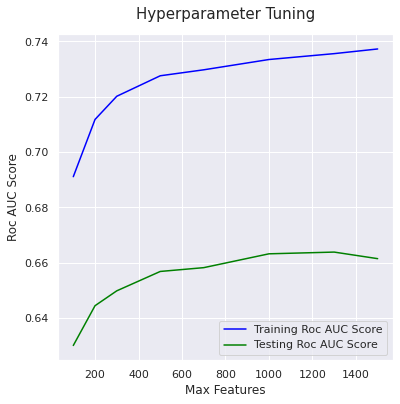

In [ ]:
plt.rc("figure", figsize=(6, 6))
plt.plot(max_features, training_auc, color='blue', label='Training Roc AUC Score')
plt.plot(max_features, testing_auc, color='green', label='Testing Roc AUC Score')
plt.xlabel('Max Features')
plt.ylabel('Roc AUC Score')
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()
#plt.savefig('error.png') 

In [ ]:
# Submuestro y balanceo de clases
data_sample_min = data_train.groupby('stars')
data_sample_min = pd.DataFrame(data_sample_min.apply(lambda x: x.sample(data_sample_min.size().min()-4500).reset_index(drop=True))).reset_index(drop=True)

In [ ]:
data_sample_min.shape

(2500, 11)

In [ ]:
data_sample_min.head(2)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,stars_calif,review_all,Review_Cleaning
0,es_0031893,product_es_0586828,reviewer_es_0681036,1,"Los he devuelto, son demasiado endebles. Para ...",Plástico endeble,es,home,0,"Plástico endeble Los he devuelto, son demasiad...","[plastico, endeble, devolver, demasiar, endebl..."
1,es_0940941,product_es_0355999,reviewer_es_0254513,1,"De ""doble"" nada, ni se parece en tamaño a la d...",Timo,es,home,0,"Timo De ""doble"" nada, ni se parece en tamaño a...","[timo, doblar, nadar, parecer, tamano, foto, p..."


In [ ]:
titular_list_clean=[]

i=0
titular_clean=[]
for titular in data_sample_min['review_all']:
    titular=remove_accented_chars(str(titular))
    titular_clean=dataCleaning(titular)
    titular_clean=' '.join(titular_clean)
    titular_list_clean.append(titular_clean)
    i=+1

In [ ]:
result_data_sample_min = pd.Series(titular_list_clean)

In [ ]:
result_data_sample_min

0       plastico endeble devolver demasiar endeble zap...
1       timo doblar nadar parecer tamano foto parir ca...
2         llegaron rotoshable atencion cliente solucionar
3       pequeno pantalla cristal milimetros pequeno pa...
4       no querer querer dinero llevo mes esperar prod...
                              ...                        
2495                             genial sacar tender peli
2496    protector facil colocar proteger formar perfec...
2497    calidad preciar comprar parir campar material ...
2498                   auriculares perfecto enlazar movil
2499            producto producto perro parasitos comprar
Length: 2500, dtype: object

In [ ]:
len(result_data_sample_min)

2500

In [ ]:
type(result_data_sample_min)

pandas.core.series.Series

In [ ]:
# Al construir el vocabulario, ignore los términos que tienen una frecuencia de documento estrictamente más alta que el umbral dado

max_dfs  = [0.8,0.9,1]
labels = [1, 2, 3, 4, 5]
training_auc = [] 
testing_auc = []


for max_df in max_dfs:
    # Vectorizo con count vectorizer
    cvectorizer = CountVectorizer(lowercase=True, strip_accents='unicode', decode_error='ignore', max_df=max_df)
    matriz_titulos_count_vectorizer = cvectorizer.fit_transform(result_data_sample_min)

    X = matriz_titulos_count_vectorizer.toarray()
    Y = data_sample_min['stars']

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

    # Definir el modelo y entreno
    clf = LGBMClassifier().fit(X_train,Y_train)
    
    # Binarize ytest with shape (n_samples, n_classes)
    Y_test = label_binarize(Y_test, classes=labels)

    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    y_train_preds = label_binarize(y_train_pred, classes=labels)
    train_roc_auc_score = roc_auc_score(Y_train,y_train_preds, multi_class='ovr')
    
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    y_test_preds = label_binarize(y_test_pred, classes=labels)
    test_roc_auc_score = roc_auc_score(Y_test,y_test_preds, multi_class='ovr') 
    
    # Agregar la información a las listas
    training_auc.append(train_roc_auc_score)
    testing_auc.append(test_roc_auc_score)

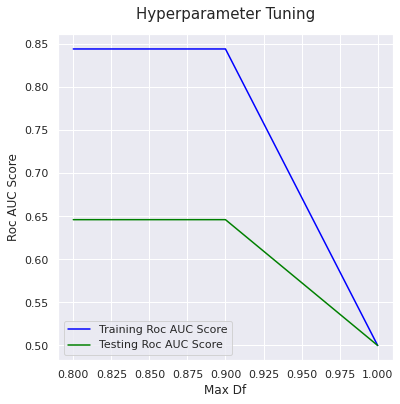

In [ ]:
plt.rc("figure", figsize=(6, 6))
plt.plot(max_dfs, training_auc, color='blue', label='Training Roc AUC Score')
plt.plot(max_dfs, testing_auc, color='green', label='Testing Roc AUC Score')
plt.xlabel('Max Df')
plt.ylabel('Roc AUC Score')
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()
plt.show()

Parámetros de TF-IDF Vectorizer

In [ ]:
max_features = [100,200,300,500,700,1000,1300,1500]
labels = [1, 2, 3, 4, 5]
training_auc = [] 
testing_auc = []


for max_feature in max_features:
    # Vectorizo con count vectorizer
    tvectorizer = TfidfVectorizer(lowercase=True, strip_accents='unicode', decode_error='ignore', max_features=max_feature)
    matriz_titulos_count_vectorizer = tvectorizer.fit_transform(result)

    X = matriz_titulos_count_vectorizer.toarray()
    Y = data_train['stars']

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

    # Definir el modelo y entreno
    clf = LGBMClassifier().fit(X_train,Y_train)
    
    # Binarize ytest with shape (n_samples, n_classes)
    Y_test = label_binarize(Y_test, classes=labels)

    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    y_train_preds = label_binarize(y_train_pred, classes=labels)
    train_roc_auc_score = roc_auc_score(Y_train,y_train_preds, multi_class='ovr')
    
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    y_test_preds = label_binarize(y_test_pred, classes=labels)
    test_roc_auc_score = roc_auc_score(Y_test,y_test_preds, multi_class='ovr') 
    
    # Agregar la información a las listas
    training_auc.append(train_roc_auc_score)
    testing_auc.append(test_roc_auc_score)

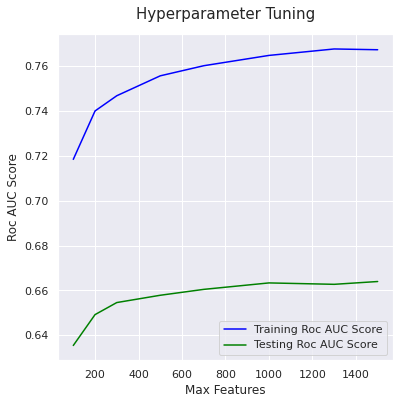

In [ ]:
plt.rc("figure", figsize=(6, 6))
plt.plot(max_features, training_auc, color='blue', label='Training Roc AUC Score')
plt.plot(max_features, testing_auc, color='green', label='Testing Roc AUC Score')
plt.xlabel('Max Features')
plt.ylabel('Roc AUC Score')
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()
#plt.savefig('error.png') 

In [ ]:
# Al construir el vocabulario, ignore los términos que tienen una frecuencia de documento estrictamente más alta que el umbral dado

max_dfs  = [0.7,0.8,0.9,1]
labels = [1, 2, 3, 4, 5]
training_auc = [] 
testing_auc = []


for max_df in max_dfs:
    # Vectorizo con count vectorizer
    tvectorizer = TfidfVectorizer(lowercase=True, strip_accents='unicode', decode_error='ignore', max_df=max_df)
    matriz_titulos_count_vectorizer = tvectorizer.fit_transform(result_data_sample_min)

    X = matriz_titulos_count_vectorizer.toarray()
    Y = data_sample_min['stars']

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

    # Definir el modelo y entreno
    clf = LGBMClassifier().fit(X_train,Y_train)
    
    # Binarize ytest with shape (n_samples, n_classes)
    Y_test = label_binarize(Y_test, classes=labels)

    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    y_train_preds = label_binarize(y_train_pred, classes=labels)
    train_roc_auc_score = roc_auc_score(Y_train,y_train_preds, multi_class='ovr')
    
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    y_test_preds = label_binarize(y_test_pred, classes=labels)
    test_roc_auc_score = roc_auc_score(Y_test,y_test_preds, multi_class='ovr') 
    
    # Agregar la información a las listas
    training_auc.append(train_roc_auc_score)
    testing_auc.append(test_roc_auc_score)

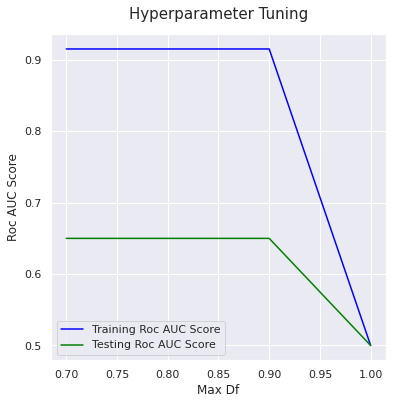

In [ ]:
plt.rc("figure", figsize=(6, 6))
plt.plot(max_dfs, training_auc, color='blue', label='Training Roc AUC Score')
plt.plot(max_dfs, testing_auc, color='green', label='Testing Roc AUC Score')
plt.xlabel('Max Df')
plt.ylabel('Roc AUC Score')
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()
plt.show()

VECTORIZACIÓN FINAL

En ambos casos, los parámetros que mejorarían nuestra performance del modelo son similares, motivo por el cual elegiremos los mismos para ambos tipos de vectorización.

In [ ]:
# numero minimo y maximo de tokens consecutivos que se consideran
MIN_NGRAMS=1
MAX_NGRAMS=4
# cantidad maxima de docs que tienen que tener a un token para conservarlo.
MAX_DF= 0.8
max_features=1000

In [ ]:
cvectorizer = CountVectorizer(lowercase=True, strip_accents='unicode', decode_error='ignore',
                             ngram_range=(MIN_NGRAMS, MAX_NGRAMS), max_df=MAX_DF, max_features=max_features)
matriz_titulos_count_vectorizer = cvectorizer.fit_transform(result)

In [ ]:
tvectorizer = TfidfVectorizer(lowercase=True, strip_accents='unicode', decode_error='ignore',
                             ngram_range=(MIN_NGRAMS, MAX_NGRAMS), max_df=MAX_DF, max_features=max_features)
matriz_titulos_count_tvectorizer = tvectorizer.fit_transform(result)

# 4. Modelos de Machine Learning <a name="ModelodeMachineLearning"></a>

En este apartado nos propondremos contruir un clasificador que prediga la cantidad de estrellas con la que puntuará un cliente una compra a partir de su reseña. Para ello, trabajaremos con las siguientes iteraciones:

* Iteración 1: Se entrenará un modelo LGBM Classifier con CountVectorizer y TfidfVectorizer para probar el desempeño de ambos vectorizers y elegir el que mejor performe. Asimimo, evaluaremos la importancia de atributos y observaremos gráficamente las reglas de decisión principales. El modelo resultante de este apartado será nuestro benchmark.

* Iteración 2: Se seleccionarán las características principales de nuestro total de features lo cual nos permitirá entrenar el modelo con más instancias. Asimismo, ee entrenarán diferentes modelos para evaluar si es necesario aplicar una técnica de boosting o podemos obtener los mismos resultados con un modelo más simple.

* Iteración 3: Se seleccionará el mejor modelo y se aplicará Randomized Search para optimizarán hiperparámtros y evaluar la estabilidad del modelo con 5 k fold validation.

Como consideración, para evaluar el rendimiento del modelo multiclase, se utilizará la métrica con ROC Curve, la cual calcula el área bajo la curva del receptor (ROC AUC) a partir de los resultados de las predicciones, cuyo resultado será el valor promedio del score obtenido en cada una de las clases contra todas las demás.

## 4.1 Iteración 1 <a name="MMLIteración1 "></a>

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import graphviz

In [ ]:
# COUNT VECTORIZER
X1 = matriz_titulos_count_vectorizer.toarray()
Y1 = data_train['stars']

X_train, X_test, y_train, y_test = train_test_split(X1,Y1,test_size=0.3,random_state=42,stratify=Y1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(52500, 1000)
(22500, 1000)


Modelo: LGBM_cl
ROC AUC Train 0.702
ROC AUC Test 0.6731944444444444


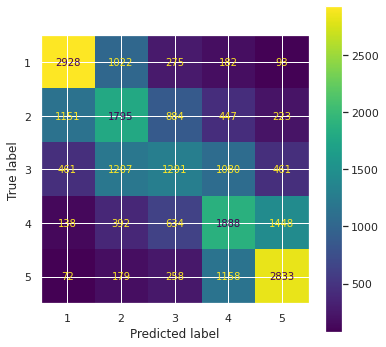

In [ ]:
LGBM_cl= LGBMClassifier().fit(X_train,y_train)

labels = [1, 2, 3, 4, 5]
# Binarize ytest with shape (n_samples, n_classes)
y_testb = label_binarize(y_test, classes=labels)

y_train_pred = LGBM_cl.predict(X_train)
y_test_pred = LGBM_cl.predict(X_test)

# Binarize ypreds with shape (n_samples, n_classes)
y_train_preds = label_binarize(y_train_pred, classes=labels)
y_test_preds = label_binarize(y_test_pred, classes=labels)
    
print('Modelo: LGBM_cl')
print('ROC AUC Train', roc_auc_score(y_train,y_train_preds, multi_class='ovr'))
print('ROC AUC Test', roc_auc_score(y_test,y_test_preds, multi_class='ovr'))
metrics.plot_confusion_matrix(LGBM_cl, X_test, y_test, values_format = '.0f')
plt.show()
print('\n')

In [ ]:
# TF-IDF VECTORIZER
X2 = matriz_titulos_count_tvectorizer.toarray()
Y2 = data_train['stars']

X_train, X_test, y_train, y_test = train_test_split(X2,Y2,test_size=0.3,random_state=42,stratify=Y2)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(52500, 1000)
(22500, 1000)


Modelo: LGBM_cl
ROC AUC Train 0.715392857142857
ROC AUC Test 0.6748888888888889


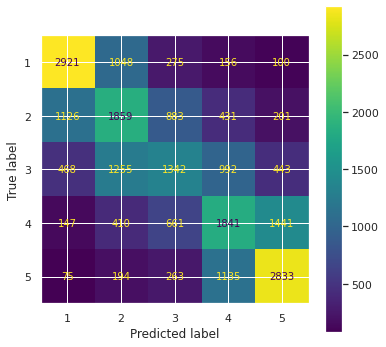

In [ ]:
LGBM_cl= LGBMClassifier().fit(X_train,y_train)

labels = [1, 2, 3, 4, 5]
# Binarize ytest with shape (n_samples, n_classes)
y_testb = label_binarize(y_test, classes=labels)

y_train_pred = LGBM_cl.predict(X_train)
y_test_pred = LGBM_cl.predict(X_test)

# Binarize ypreds with shape (n_samples, n_classes)
y_train_preds = label_binarize(y_train_pred, classes=labels)
y_test_preds = label_binarize(y_test_pred, classes=labels)
    
print('Modelo: LGBM_cl')
print('ROC AUC Train', roc_auc_score(y_train,y_train_preds, multi_class='ovr'))
print('ROC AUC Test', roc_auc_score(y_test,y_test_preds, multi_class='ovr'))
metrics.plot_confusion_matrix(LGBM_cl, X_test, y_test, values_format = '.0f')
plt.show()
print('\n')

Se puede observar una pequeña mejoría aplicando tf-idf, por lo que se seleccionará dicho modelo como nuestro benchmark.

In [ ]:
# Ordeno las features más importantes
thresholds = sorted(LGBM_cl.feature_importances_, reverse=True)

# Me quedo con las primeras 100
thresholds = thresholds[:100]

In [ ]:
# Evalúo el ROC AUC que obtengo incorporando de a una feature al modelo
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(LGBM_cl, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # train model
    selection_model = LGBMClassifier(random_state=7)
    selection_model.fit(select_X_train, y_train)
    
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    y_preds = label_binarize(y_pred, classes=labels)
    predictions = [np.round(value) for value in y_preds]
    roc_auc = roc_auc_score(y_test,predictions, multi_class='ovr')
    print("Thresh=%.3f, n=%d, ROC AUC: %.2f%%" % (thresh, select_X_train.shape[1], roc_auc*100.0))

Thresh=384.000, n=1, ROC AUC: 56.83%
Thresh=298.000, n=2, ROC AUC: 57.34%
Thresh=217.000, n=3, ROC AUC: 57.77%
Thresh=205.000, n=4, ROC AUC: 58.08%
Thresh=203.000, n=5, ROC AUC: 58.55%
Thresh=192.000, n=6, ROC AUC: 58.84%
Thresh=185.000, n=7, ROC AUC: 59.17%
Thresh=170.000, n=8, ROC AUC: 59.35%
Thresh=153.000, n=9, ROC AUC: 59.60%
Thresh=151.000, n=10, ROC AUC: 59.71%
Thresh=149.000, n=11, ROC AUC: 60.27%
Thresh=145.000, n=12, ROC AUC: 60.49%
Thresh=141.000, n=14, ROC AUC: 60.66%
Thresh=141.000, n=14, ROC AUC: 60.66%
Thresh=138.000, n=15, ROC AUC: 60.97%
Thresh=129.000, n=16, ROC AUC: 61.17%
Thresh=128.000, n=17, ROC AUC: 61.49%
Thresh=127.000, n=19, ROC AUC: 61.70%
Thresh=127.000, n=19, ROC AUC: 61.70%
Thresh=126.000, n=20, ROC AUC: 61.98%
Thresh=122.000, n=21, ROC AUC: 61.98%
Thresh=121.000, n=22, ROC AUC: 62.28%
Thresh=118.000, n=23, ROC AUC: 62.35%
Thresh=113.000, n=24, ROC AUC: 62.41%
Thresh=110.000, n=25, ROC AUC: 62.61%
Thresh=105.000, n=26, ROC AUC: 62.67%
Thresh=104.000, n=28,

In [ ]:
# Genero un dataframe con las features y su importancia

atributos = tvectorizer.get_feature_names()
feat_imp = pd.DataFrame({'Atributo':atributos,'importancia':LGBM_cl.feature_importances_}).sort_values('importancia',ascending=False)
most_important_features = feat_imp[:200]

# Exporto para poder analizar
#feat_imp.to_excel('feature_importance.xlsx')

In [ ]:
feat_imp.head()

,Atributo,importancia
589,no,384
713,perfecto,298
303,encantar,217
712,perfectamente,205
411,genial,203


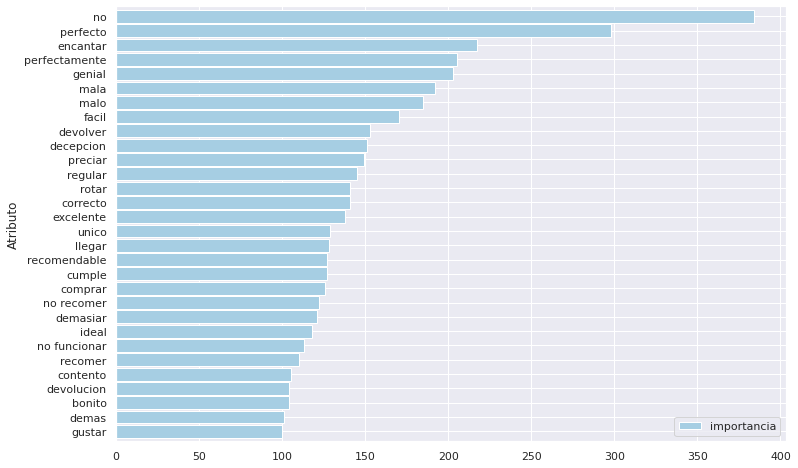

In [ ]:
N = 30
first_N = feat_imp[:N]

first_N[:30].sort_values('importancia',ascending=True).plot.barh(x='Atributo', width=.9, colormap='Paired', figsize=(12, 8))

In [ ]:
# print column headers
print('{:15} | {:15} | {:8} | {:20} | {:11} | {:8} | {:8} | {:8} | '.format('TEXT','LEMMA_','POS_','HEAD','DEP_','SHAPE_','IS_ALPHA','IS_STOP'))

for i in first_N['Atributo']:
  doc=nlp(i)
  # print various SpaCy POS attributes
  for token in doc:
    print('{:15} | {:15} | {:8} | {:20} | {:11} | {:8} | {:8} | {:8} |'.format(token.text, token.lemma_, token.pos_, token.head.text, token.dep_ , token.shape_, token.is_alpha, token.is_stop))

TEXT            | LEMMA_          | POS_     | HEAD                 | DEP_        | SHAPE_   | IS_ALPHA | IS_STOP  | 
no              | no              | ADV      | no                   | ROOT        | xx       |        1 |        1 |
perfecto        | perfecto        | ADJ      | perfecto             | ROOT        | xxxx     |        1 |        0 |
encantar        | encantar        | VERB     | encantar             | ROOT        | xxxx     |        1 |        0 |
perfectamente   | perfectamente   | ADV      | perfectamente        | ROOT        | xxxx     |        1 |        0 |
genial          | genial          | ADJ      | genial               | ROOT        | xxxx     |        1 |        0 |
mala            | malo            | ADJ      | mala                 | ROOT        | xxxx     |        1 |        0 |
malo            | malo            | ADJ      | malo                 | ROOT        | xxxx     |        1 |        0 |
facil           | facil           | ADJ      | facil           

In [ ]:
DecisionTree_cl = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5).fit(X_train,y_train)

labels = [1, 2, 3, 4, 5]
# Binarize ytest with shape (n_samples, n_classes)
y_testb = label_binarize(y_test, classes=labels)

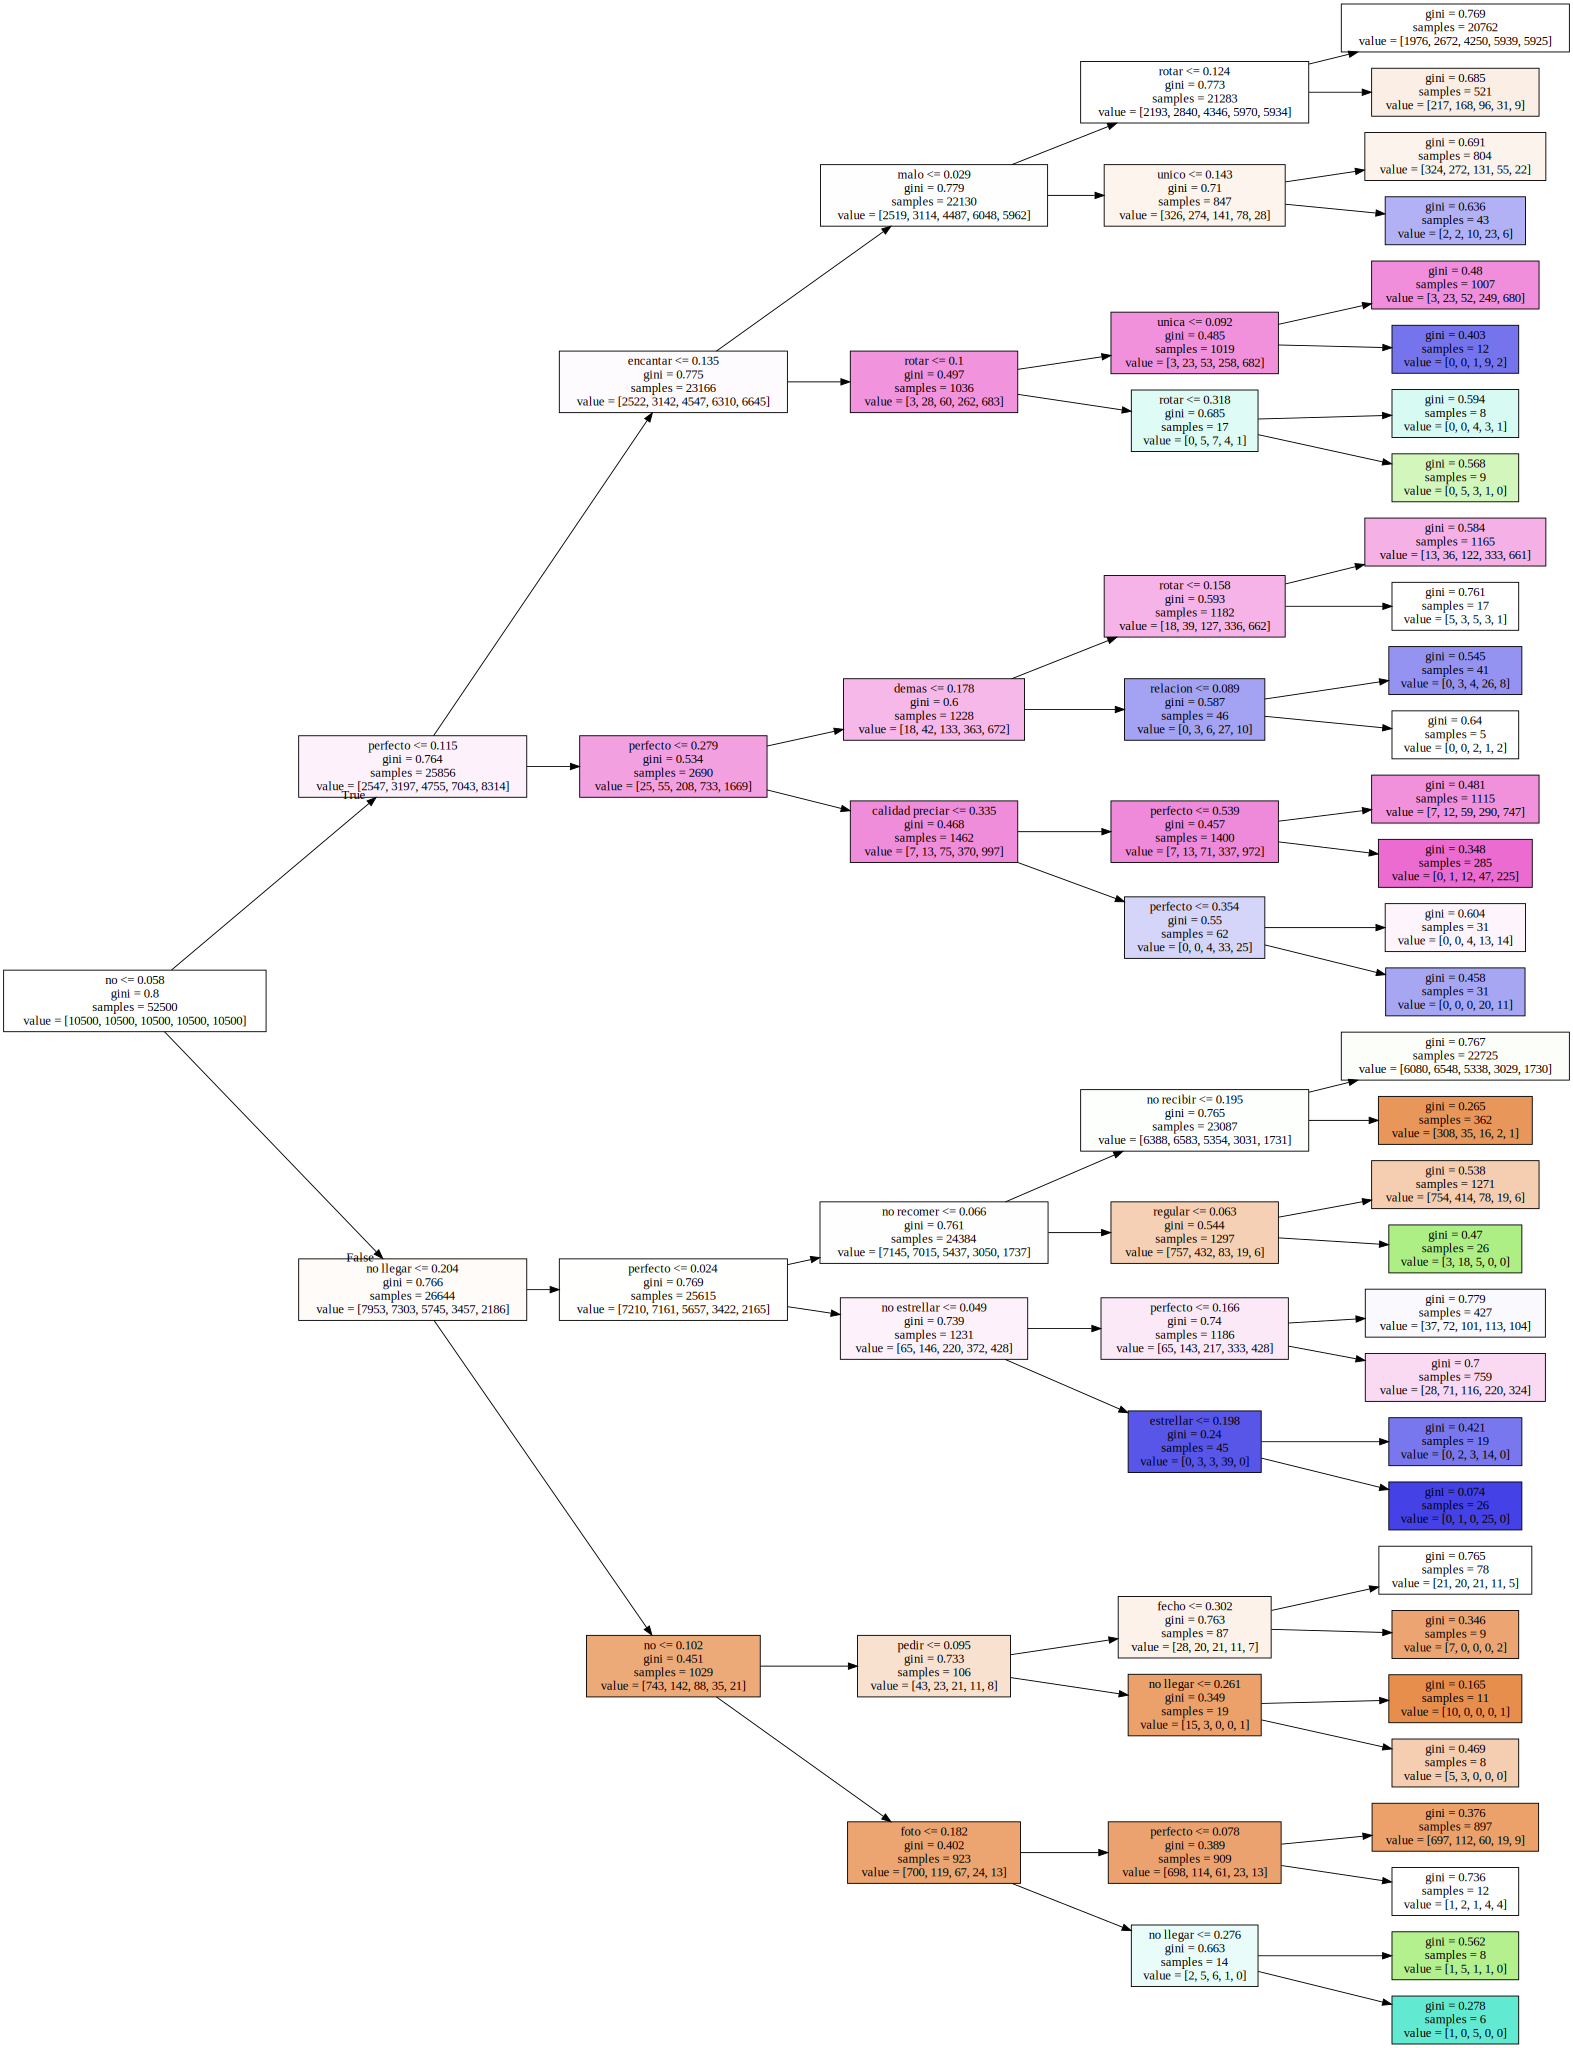

In [ ]:
dot_data = tree.export_graphviz(DecisionTree_cl, out_file=None, feature_names=tvectorizer.get_feature_names(),rotate = True, filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

## 4.2 Iteración 2 <a name="MMLIteración2"></a>

En la siguiente iteración, entrenaremos los siguientes modelos con las características principales seleccionadas:

* Gaussian Classifier
* K Neighbors Classifier
* Decision Tree Classifier
* Random Forest Classifier
* XGB Classifier
* LGBM Classifier

Asimismo, redefiniremos la función de normalización de texto quedándonos sólo con los tokens cuyo part of speach está dentro de las 30 características más importantes.

In [ ]:
# Submuestro y balanceo de clases
data_sample = data.groupby('stars')
data_sample = pd.DataFrame(data_sample.apply(lambda x: x.sample(data_sample.size().min()-25000).reset_index(drop=True))).reset_index(drop=True)
data_train = data_sample.copy()

In [ ]:
data_train.shape

(75000, 10)

In [ ]:
def dataCleaning(sentence):
    doc = nlp(sentence)
    tokens = []
    for token in doc:
        if len(token)>1: #si el token tiene más de 1 caracteres
            # Forma base del token, sin sufijos de flexión. Y lo pasamos a minuscula.
            if token.lemma_ != '-PRON-' and (token.pos_ == 'ADV' or token.pos_ == 'ADJ' or token.pos_ == 'VERB' or token.pos_ == 'PROPN' or token.pos_ == 'NOUN'): 
              temp = token.lemma_.lower()
              tokens.append(temp)
              clean_tokens = []
              # Quitamos stopswords
              for token in tokens:
                  #if token not in punct and token not in stopwords:
                  if token not in stopwords:
                      clean_tokens.append(token)
    return clean_tokens

def remove_accented_chars(text):
    # Removemos los caracteres especiales
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Eliminamos cualquier caracter que no sen los siguientes: a-z A-Z 0-9   
    pattern = r'[^a-zA-Z0-9\s]' 
    text = re.sub(pattern, '', text)
     
    return text

In [ ]:
titular_list_clean=[]

i=0
titular_clean=[]
for titular in data_train['review_all']:
    titular=remove_accented_chars(str(titular))
    titular_clean=dataCleaning(titular)
    titular_clean=' '.join(titular_clean)
    titular_list_clean.append(titular_clean)
    i=+1

In [ ]:
result = pd.Series(titular_list_clean)

In [ ]:
len(result)

50000

In [ ]:
X_modelo = pd.DataFrame(matriz_titulos_count_tvectorizer.toarray(), columns=tvectorizer.get_feature_names())
X_modelo.head(2)

,abajar,abrir,absoluto,acabar,accesorio,aceitar,aceptable,acertar,aconsejar,acoplar,adaptador,adaptar,adaptar perfectamente,adecuar,ademar,adhesivo,agarrar,agradable,aguantar,aguar,agujerar,agujero,ahorrar,aire,ajustar,ajustar perfectamente,algun,altavoz,alto,altura,amarillo,amazon,amazon no,amplio,ancho,andar,ano,anunciar,apagar,aparato,...,unica pegar,unico,unidad,usarla,usarlo,usb,util,utiles,utilidad,utilizar,valer,valer penar,valoracion,valorar,variedad,velocidad,vendedor,vendedor no,vender,venia,venian,venir,ventilador,verano,verde,verguenza,version,vestir,viajar,vida,video,videos,viene,volumen,volver,volveria,volveria comprar,wifi,xiaomi,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Seleccionamos sólo las características principales
colname = X_modelo.columns.values.tolist()
predictors = most_important_features['Atributo'].unique().tolist()

X1 = X_modelo[predictors]
Y1 = data_train['stars']

X_train, X_test, y_train, y_test = train_test_split(X1,Y1,test_size=0.3,random_state=42,stratify=Y1)

In [ ]:
Gaussian_cl = GaussianNB().fit(X_train,y_train)
KNeighbors_cl = KNeighborsClassifier().fit(X_train,y_train)
DecisionTree_cl = DecisionTreeClassifier().fit(X_train,y_train)
RandomForest_cl = RandomForestClassifier().fit(X_train,y_train)
XGB_cl = XGBClassifier().fit(X_train,y_train)
LGBM_cl= LGBMClassifier().fit(X_train,y_train)

In [ ]:
labels = [1, 2, 3, 4, 5]
# Binarize ytest with shape (n_samples, n_classes)
y_testb = label_binarize(y_test, classes=labels)

Modelo: Gaussian Classifier
ROC AUC Train 0.6239404761904762
ROC AUC Test 0.6187777777777778


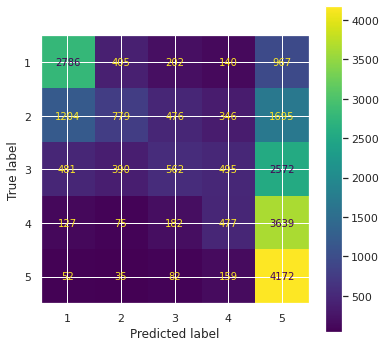



Modelo: K Neighbors Classifier
ROC AUC Train 0.7366071428571429
ROC AUC Test 0.6205833333333333


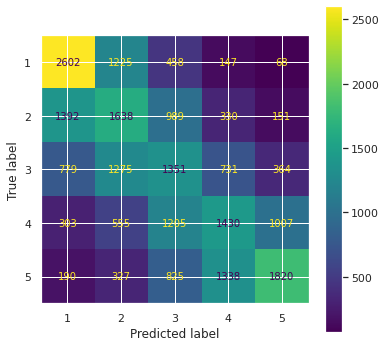



Modelo: Decision Tree Classifier
ROC AUC Train 0.9782023809523809
ROC AUC Test 0.6071666666666666


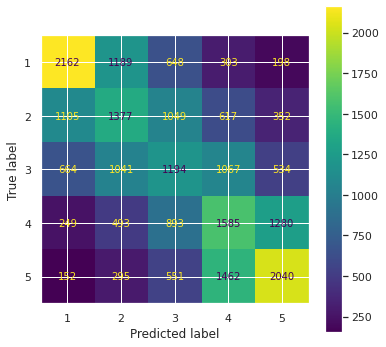



Modelo: Random Forest Classifier
ROC AUC Train 0.9781785714285715
ROC AUC Test 0.6418055555555555


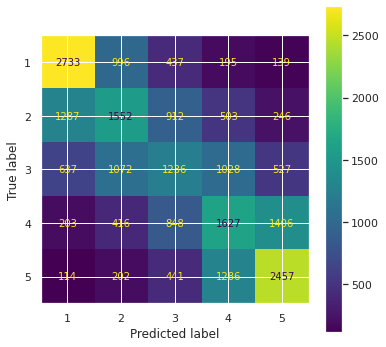



Modelo: XGB Classifier
ROC AUC Train 0.6617499999999998
ROC AUC Test 0.6472777777777778


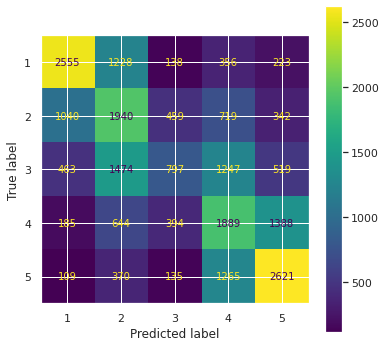



Modelo: LGBM Classifier
ROC AUC Train 0.7047857142857141
ROC AUC Test 0.6720833333333334


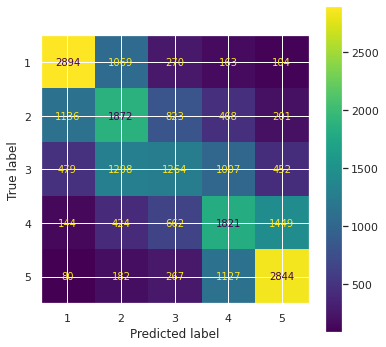

In [ ]:
modelos = ['Gaussian Classifier', 'K Neighbors Classifier', 'Decision Tree Classifier', 'Random Forest Classifier', 'XGB Classifier', 'LGBM Classifier']

for i, model in enumerate([Gaussian_cl, KNeighbors_cl, DecisionTree_cl, RandomForest_cl, XGB_cl, LGBM_cl]):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # Binarize ypreds with shape (n_samples, n_classes)
    y_train_preds = label_binarize(y_train_pred, classes=labels)
    y_test_preds = label_binarize(y_test_pred, classes=labels)
        
    print(f'Modelo: {modelos[i]}')
    print('ROC AUC Train', roc_auc_score(y_train,y_train_preds, multi_class='ovr'))
    print('ROC AUC Test', roc_auc_score(y_test,y_test_preds, multi_class='ovr'))
    metrics.plot_confusion_matrix(model, X_test, y_test, values_format = '.0f')
    plt.show()
    print('\n')

De los modelos construidos en la presente iteración, los modelos de árboles de clasificación son lo únicos que han podido predecir mejor las clases extremas (1 estrella y 5 estrella) y presentado un menor error en la predicción de las clases ambiguas (2, 3 y 4 estrellas). Sin embaego, nuestro modelo de benchmark junto con el XGB Classifier son los únicos que no han presentando indicios de overfiting. Por su mejor performance en tiempos de ejecución y en rendimientos de la métrica elegida, es que continuaremos trabajando con el LGBM Classifier.

## 4.3 Iteración 3 <a name="MMLIteración3"></a>

Por los motivos anteriormente enunciadas, no podremos hacer una búsqueda exhautiva de hiperparámetros con técnicas como Grid Search, ya que por la cantidad de features la ejecución se demora más de los límites de tiempos permitidos por Colab. 

En la presente iteración realizaremos una optimización de hiperparámetros con Random Search aplicado k fold validation, cuya técnica nos permite recorrer una mayor rango de posibilidades a una cantidad de iteracion prefijadas. 

In [ ]:
param_trees = {'n_estimators': [100, 150, 200, 250],  # Número de árboles 
               'metodo': ['SVD', 'KBEST'],
               'max_depth': [10, 15, 20, 50, 60,-1],  # Profundidad
               'num_leaves': [7, 14, 21, 30, 50, 60], # Máximo de hojas de árboles
               'min_child_samples':[15, 20, 30, -1],  # Número mínimo de datos necesarios en un niño (hoja)
               }

roc_auc_ovr_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

# ESTRATEGIA 2: Random Search
model = LGBMClassifier(random_state=42, subsample=0.7)
rs = RandomizedSearchCV(model, param_trees, n_iter=50, scoring=roc_auc_ovr_scorer, verbose=2 , n_jobs=3)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  6.6min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 45.2min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed: 78.1min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=42, reg_alpha=0.0,
                                            reg_lambda=0.0, sil...
                   iid='deprecated', n_iter=50, n_jobs=3,
                   param_distributions={'max_depth': [10, 15, 20, 5

In [ ]:
print("Mejores parametros: "+str(rs.best_params_))
print("Mejor Score: "+str(rs.best_score_)+'\n')

scores_2 = pd.DataFrame(rs.cv_results_)
scores_2

Mejores parametros: {'num_leaves': 30, 'n_estimators': 250, 'min_child_samples': 30, 'metodo': 'KBEST', 'max_depth': -1}
Mejor Score: 0.8066200158730158



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_min_child_samples,param_metodo,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.7,0.1,0.5,0.1,7,100,30,KBEST,20,"{'num_leaves': 7, 'n_estimators': 100, 'min_ch...",0.8,0.8,0.8,0.8,0.8,0.8,0.0,37
1,0.2,0.0,0.0,0.0,50,150,-1,KBEST,-1,"{'num_leaves': 50, 'n_estimators': 150, 'min_c...",nan,nan,nan,nan,nan,nan,nan,48
2,75.5,0.8,1.9,0.1,60,100,30,SVD,50,"{'num_leaves': 60, 'n_estimators': 100, 'min_c...",0.8,0.8,0.8,0.8,0.8,0.8,0.0,11
3,66.4,0.4,1.8,0.1,21,200,20,KBEST,-1,"{'num_leaves': 21, 'n_estimators': 200, 'min_c...",0.8,0.8,0.8,0.8,0.8,0.8,0.0,2
4,67.1,0.7,1.9,0.1,21,200,15,SVD,50,"{'num_leaves': 21, 'n_estimators': 200, 'min_c...",0.8,0.8,0.8,0.8,0.8,0.8,0.0,5
5,0.2,0.0,0.0,0.0,60,250,-1,KBEST,10,"{'num_leaves': 60, 'n_estimators': 250, 'min_c...",nan,nan,nan,nan,nan,nan,nan,47
6,0.2,0.0,0.0,0.0,21,100,-1,SVD,60,"{'num_leaves': 21, 'n_estimators': 100, 'min_c...",nan,nan,nan,nan,nan,nan,nan,46
7,84.6,0.9,2.4,0.1,30,200,20,SVD,-1,"{'num_leaves': 30, 'n_estimators': 200, 'min_c...",0.8,0.8,0.8,0.8,0.8,0.8,0.0,4
8,0.2,0.0,0.0,0.0,50,200,-1,SVD,20,"{'num_leaves': 50, 'n_estimators': 200, 'min_c...",nan,nan,nan,nan,nan,nan,nan,45
9,80.5,0.7,2.3,0.1,30,200,20,SVD,20,"{'num_leaves': 30, 'n_estimators': 200, 'min_c...",0.8,0.8,0.8,0.8,0.8,0.8,0.0,6


In [ ]:
LGBM_clf = LGBMClassifier(n_estimators=250, metodo='KBEST', min_child_samples=30, num_leaves=30, random_state=42)
LGBM_clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metodo='KBEST', min_child_samples=30, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=250, n_jobs=-1, num_leaves=30,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

ROC AUC Train 0.7295238095238095
ROC AUC Test 0.6726666666666666


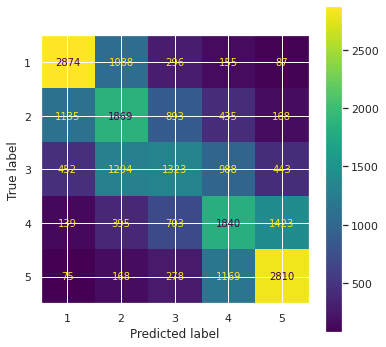

In [ ]:
y_train_pred = LGBM_clf.predict(X_train)
y_test_pred = LGBM_clf.predict(X_test)

# Binarize ypreds with shape (n_samples, n_classes)
y_train_preds = label_binarize(y_train_pred, classes=labels)
y_test_preds = label_binarize(y_test_pred, classes=labels)
        
print('ROC AUC Train', roc_auc_score(y_train,y_train_preds, multi_class='ovr'))
print('ROC AUC Test', roc_auc_score(y_test,y_test_preds, multi_class='ovr'))
metrics.plot_confusion_matrix(LGBM_clf, X_test, y_test, values_format = '.0f')
plt.show()

Con nuestra optimización, obtenemos una performace muy parecida a la presentada previamente. Si bien no se ha logrdo mejorar el rendimiento de la clasificación, nos aseguramos de que nuestros resultados son estables y no producto del azar.

# 5. Investigación <a name="Investigacion"></a>

En el apartado anterior pudimos observar que en el mejor de los casos, logramos construir un modelo que puede diferenciar una review de 1 estrella a una de 5 estrellas, pero que no logra clasificar adecuadamente aquellas reviews con puntuaciones intermedias de 2, 3 y 4 estrellas. 

En este punto nos preguntamos: ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta.

Teniendo en cuenta que una puntuación de 2 a 3 estrellas o de 3 a 4 estrellas puede ser una apreciación muy subjetiva colmada de grises, es que nuestra hipótesis será que un clasificador binario performará mucho mejor en la tarea de predecir si un producto será puntuado como positivo o negativo.

Para realizar esta investigación realizaremos el mismo proceso de Normalización y Vectorización de los datos, tomando sólo aquellas reviews que pertenezcan a alguno de los extremos de nuestro problema: 
* Reviews Negativas: 1 y 2 estrellas
* Reviews Positivas: 4 y 5 estellas.

Las instancias pertenecientes a 3 estrellas serán desestimadas por 2 motivos: el primero, por practicidad para el balanceo de clases y el segundo, porque en el hipotético caso en que el usuario tuviese únicamente la opción de calificar como conforme o inconforme, la situación parcial de 3 estrellas queda sin efecto.

En el presente aparatado, construiremos los mismos clasificadores que en el segmento anterior y evaluaremos su performance con la métrica de Accuracy, ya que es equivalente a ROC AUC para clases balanceadas. Finalmente, optimizatemos hiperparámetros del modelo que obtenga mejor rendimiento.

In [ ]:
# Balanceamos clases y eliminamos el punto medio, cuya existencia no sería tal en un problema de clasificación positiva / negativa:

data_train_sent = data_train[data_train['stars']!=3]

In [ ]:
data_train_sent.stars_calif.value_counts()

1    30000
0    30000
Name: stars_calif, dtype: int64

In [ ]:
titular_list_clean=[]

i=0
titular_clean=[]
for titular in data_train_sent['review_all']:
    titular=remove_accented_chars(str(titular))
    titular_clean=dataCleaning(titular)
    titular_clean=' '.join(titular_clean)
    titular_list_clean.append(titular_clean)
    i=+1

In [ ]:
result_sent = pd.Series(titular_list_clean)

In [ ]:
result_sent

0        no comprar caja bonito defecto melodia mitad c...
1        mala calidad cuidadoso no durar no recomendabl...
2        no llegar esperar tenia llegar no noticiar no ...
3        no usarlo perder pieza abrocharlo no usarlo no...
4        no pega bonito no pega caer no validar ningun ...
                               ...                        
59995    comprar bonito suave excelente calidad preciar...
59996    comprar comprar llegar rapido recomiendo produ...
59997    anita precioso quedo bonito preciar foto envio...
59998    geniales calidad tejer duradero no estropear l...
59999    perfectas ligero resistente ocupar prender no ...
Length: 60000, dtype: object

In [ ]:
# numero minimo y maximo de tokens consecutivos que se consideran
MIN_NGRAMS=1
MAX_NGRAMS=4
# cantidad maxima de docs que tienen que tener a un token para conservarlo.
MAX_DF= 0.8
max_features=1000

In [ ]:
tvectorizer = TfidfVectorizer(lowercase=True, strip_accents='unicode', decode_error='ignore',
                             ngram_range=(MIN_NGRAMS, MAX_NGRAMS), max_df=MAX_DF, max_features=max_features)
matriz_titulos_tfidf_tvectorizer = tvectorizer.fit_transform(result_sent)

In [ ]:
X4 = matriz_titulos_tfidf_tvectorizer.toarray()
Y4 = data_train_sent['stars_calif']

X_train, X_test, y_train, y_test = train_test_split(X4,Y4,test_size=0.3,random_state=42,stratify=Y4)

In [ ]:
Gaussian_cl = GaussianNB().fit(X_train,y_train)
KNeighbors_cl = KNeighborsClassifier().fit(X_train,y_train)
DecisionTree_cl = DecisionTreeClassifier().fit(X_train,y_train)
RandomForest_cl = RandomForestClassifier().fit(X_train,y_train)
XGB_cl = XGBClassifier().fit(X_train,y_train)
LGBM_cl= LGBMClassifier().fit(X_train,y_train)

Modelo: Gaussian Classifier
Accuracy Train 0.8438095238095238
Accuracy Test 0.8348888888888889


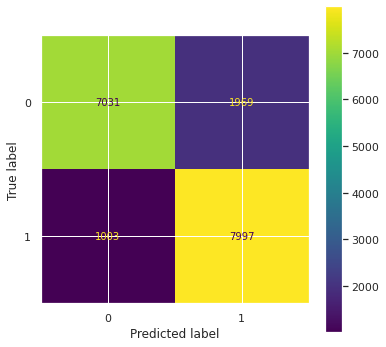



Modelo: K Neighbors Classifier
Accuracy Train 0.7840238095238096
Accuracy Test 0.7175555555555555


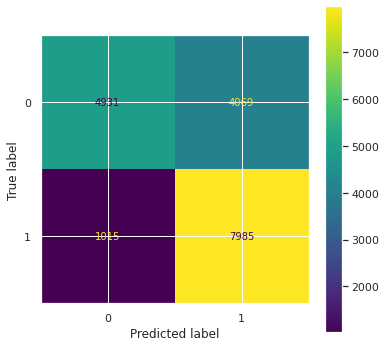



Modelo: Decision Tree Classifier
Accuracy Train 0.9957142857142857
Accuracy Test 0.81


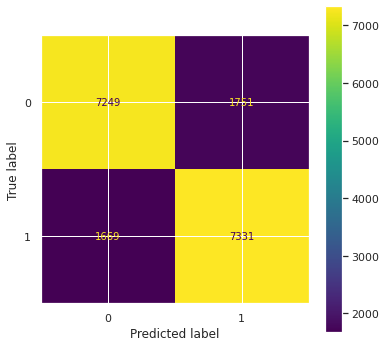



Modelo: Random Forest Classifier
Accuracy Train 0.9956904761904762
Accuracy Test 0.8724444444444445


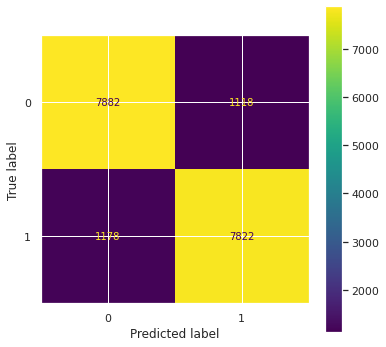



Modelo: XGB Classifier
Accuracy Train 0.8210952380952381
Accuracy Test 0.8185555555555556


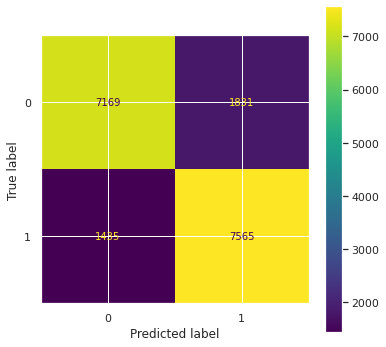



Modelo: LGBM Classifier
Accuracy Train 0.891547619047619
Accuracy Test 0.8775


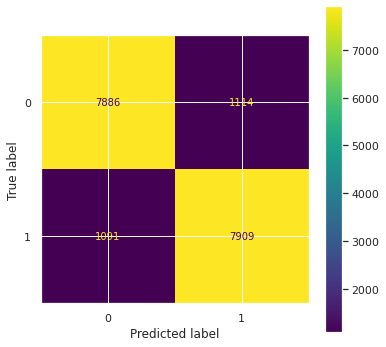

In [ ]:
modelos = ['Gaussian Classifier', 'K Neighbors Classifier', 'Decision Tree Classifier', 'Random Forest Classifier', 'XGB Classifier', 'LGBM Classifier']

for i, model in enumerate([Gaussian_cl, KNeighbors_cl, DecisionTree_cl, RandomForest_cl, XGB_cl, LGBM_cl]):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
        
    print(f'Modelo: {modelos[i]}')
    print('Accuracy Train', accuracy_score(y_train,y_train_pred))
    print('Accuracy Test', accuracy_score(y_test,y_test_pred))
    metrics.plot_confusion_matrix(model, X_test, y_test, values_format = '.0f')
    plt.show()
    print('\n')

De los modelos entrenados, nuevamente nuestro mejor clasificador es el LGBM Classifier, el obtiene el mayor Accuracy y menor presencia de overfiting.  Asimismo, se comprueba la hipótesis de que la performance del clasificador binario es muy superior que la obtenida con el problema multiclase.

In [ ]:
param_trees = {'n_estimators': [100, 150, 200, 250],  # Número de árboles 
               'metodo': ['SVD', 'KBEST'],
               'max_depth': [10, 15, 20, 50, 60,-1],  # Profundidad
               'num_leaves': [7, 14, 21, 30, 50, 60], # Máximo de hojas de árboles
               'min_child_samples':[15, 20, 30, -1],  # Número mínimo de datos necesarios en un niño (hoja)
               }

# ESTRATEGIA 2: Random Search
model = LGBMClassifier(random_state=42, subsample=0.7)
rs = RandomizedSearchCV(model, param_trees, n_iter=50, scoring= 'accuracy', verbose=2 , n_jobs=3)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 18.3min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed: 28.1min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=42, reg_alpha=0.0,
                                            reg_lambda=0.0, sil...
                                            subsample_for_bin=200000,
                                            subsample_f

In [ ]:
print("Mejores parametros: "+str(rs.best_params_))
print("Mejor Score: "+str(rs.best_score_)+'\n')

scores_2 = pd.DataFrame(rs.cv_results_)
scores_2

Mejores parametros: {'num_leaves': 30, 'n_estimators': 250, 'min_child_samples': 30, 'metodo': 'KBEST', 'max_depth': -1}
Mejor Score: 0.8066200158730158



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_min_child_samples,param_metodo,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.7,0.1,0.5,0.1,7,100,30,KBEST,20,"{'num_leaves': 7, 'n_estimators': 100, 'min_ch...",0.8,0.8,0.8,0.8,0.8,0.8,0.0,37
1,0.2,0.0,0.0,0.0,50,150,-1,KBEST,-1,"{'num_leaves': 50, 'n_estimators': 150, 'min_c...",nan,nan,nan,nan,nan,nan,nan,48
2,75.5,0.8,1.9,0.1,60,100,30,SVD,50,"{'num_leaves': 60, 'n_estimators': 100, 'min_c...",0.8,0.8,0.8,0.8,0.8,0.8,0.0,11
3,66.4,0.4,1.8,0.1,21,200,20,KBEST,-1,"{'num_leaves': 21, 'n_estimators': 200, 'min_c...",0.8,0.8,0.8,0.8,0.8,0.8,0.0,2
4,67.1,0.7,1.9,0.1,21,200,15,SVD,50,"{'num_leaves': 21, 'n_estimators': 200, 'min_c...",0.8,0.8,0.8,0.8,0.8,0.8,0.0,5
5,0.2,0.0,0.0,0.0,60,250,-1,KBEST,10,"{'num_leaves': 60, 'n_estimators': 250, 'min_c...",nan,nan,nan,nan,nan,nan,nan,47
6,0.2,0.0,0.0,0.0,21,100,-1,SVD,60,"{'num_leaves': 21, 'n_estimators': 100, 'min_c...",nan,nan,nan,nan,nan,nan,nan,46
7,84.6,0.9,2.4,0.1,30,200,20,SVD,-1,"{'num_leaves': 30, 'n_estimators': 200, 'min_c...",0.8,0.8,0.8,0.8,0.8,0.8,0.0,4
8,0.2,0.0,0.0,0.0,50,200,-1,SVD,20,"{'num_leaves': 50, 'n_estimators': 200, 'min_c...",nan,nan,nan,nan,nan,nan,nan,45
9,80.5,0.7,2.3,0.1,30,200,20,SVD,20,"{'num_leaves': 30, 'n_estimators': 200, 'min_c...",0.8,0.8,0.8,0.8,0.8,0.8,0.0,6


In [ ]:
LGBM_clf = LGBMClassifier(n_estimators=250, metodo='KBEST', min_child_samples=30, num_leaves=30, random_state=42)
LGBM_clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metodo='KBEST', min_child_samples=30, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=250, n_jobs=-1, num_leaves=30,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

Accuracy Train 0.9152857142857143
Accuracy Test 0.8853333333333333


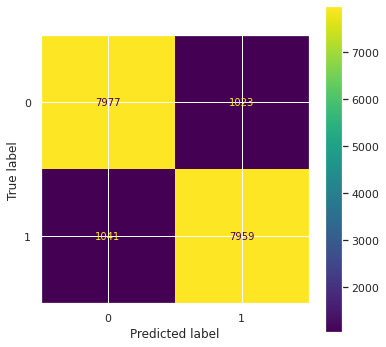

In [ ]:
y_train_pred = LGBM_clf.predict(X_train)
y_test_pred = LGBM_clf.predict(X_test)
        
print('Accuracy Train', accuracy_score(y_train,y_train_pred))
print('Accuracy Test', accuracy_score(y_test,y_test_pred))
metrics.plot_confusion_matrix(LGBM_clf, X_test, y_test, values_format = '.0f')
plt.show()

# CNN: Redes Neuronales de Convolución para NLP

En este última sección, se procederá a aplicar un modelo de Deep Learning para el análisis de sentimiento. Para ello, realizaremos lo siguiente:

* Carga de datos: Por la manera en que trabajan las librerías de Tensorflow, para este clasificador podremos utilizar la totalidad de las instancias de nuestro dataset de entrenamiento original.
* Eliminaremos las instancias cuya puntuación haya sido de 3 estrellas, manteniendo la lógica ya anunciada.
* Aplicaremos una función de limpieza más sencilla, que nos permita recorrer las 160 mil instancias más rápidamente.
* Aplicaremos Enconding con la función provista por tensorflow datasets
* Realizaremos un proceso de Padding, en el que nos aseguramos que todos los tokens tengan la misma longitud. Este proceso en necesario para poder ser utilizado posteriormente por nuestra red neuronal convolucional.
* Utilizaremos una red neuronal preentrenada, definiremos las funciones que vamos a utlizar y los parámetros a aplicar.
* Finalmente, entrenaremos nuestra red y la evaluaremos, siempre haciendo uso de las funciones de Tensorflow Keras.

In [ ]:
# Importamos Tensor Flow (descargamos la última de google colab)
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers # para las capas de convolución y las capas densas de keras
import tensorflow_datasets as tfds # utilizaremos el tokenizador de tensor flow

In [ ]:
train_data = pd.read_json("/content/drive/MyDrive/Colab Notebooks/CNN/Data/dataset_es_train.json", lines= True)
train_data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [ ]:
train_data['stars_calif'] = [1 if  train_data['stars'][i]> 3 else 0 for i in train_data.index]

In [ ]:
# Creo la variable 'review_all', que es una concatenación de 'review_title' y 'review_body'
train_data['review_all']=[(str(train_data['review_title'][i])+" "+str(train_data['review_body'][i])) for i in train_data.index]

In [ ]:
train_data = train_data[train_data['stars']!=3]

In [ ]:
train_data.stars_calif.value_counts()

1    80000
0    80000
Name: stars_calif, dtype: int64

In [ ]:
data = train_data[['review_all', 'stars_calif']]

In [ ]:
data.shape

(160000, 2)

In [ ]:
# Defino mi función de limpieza:

def clean_review(review):
    review = BeautifulSoup(review, "lxml").get_text()
    # Eliminamos cualquier caracter que no sen los siguientes: a-z A-Z 0-9 signo de admiración o puntuación y espacios
    review = re.sub(r"[^a-zA-Z0-9!?\"\s]", ' ', review)
    # Eliminamos espacios en blanco adicionales
    review = re.sub(r" +", ' ', review)
    return review

In [ ]:
# Aplico la función review por review y obtenemos nuestro corpus. El corpus es la lista de todo el texto que se quiere analizar
data_clean = [clean_review(review) for review in data.review_all]

In [ ]:
# Defino mi Y
data_labels = data.stars_calif.values

In [ ]:
len(data_clean)

160000

In [ ]:
len(data_labels)

160000

In [ ]:
# Vamos a obtener un vector de números y cada uno de llos representará una palabra diferente.
# Vamos a tokenizar y vectorizar con el corpues de tensorflow. Construye el tokenizador a base de un corpus.

# Definimos el tokenizador:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

# Tokenizamos:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [ ]:
len(data_inputs)

160000

In [ ]:
# Vamos a querer entrenar por bloques, es decir, por conjuntos de frases. Para esto necesitamos que todos tengan la misma logitud.
# El proceso de pading agrega 0 a cada una de esas frases para que todas tengan la misma longitud. Lo hacemos con 0 porque nuestro tokenizador no asigna ese numero a ninguna palabra.

# La maxima longitud a ser considerada será la longitud de la frase mas larga que tengamos en nuestro dataset
MAX_LEN = max([len(sentence) for sentence in data_inputs])

# El pad_sequences nos sirve para añadir algo al principio o al final de una secuencia
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0, # Asignamos el 0 anteriormente indicado
                                                            padding="post", # Le decimos que sea al final
                                                            maxlen=MAX_LEN) # Le pedimos que tenga la máxima longitud de la frase

In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs, data_labels, test_size=0.2, random_state=42, stratify=data_labels)

In [ ]:
# Definimos una clase que hereda de una clase de tensor flow - keras - model
class DCNN(tf.keras.Model):
    # Declaramos el constructor y definimos las capas que van a ser utilizadas
    def __init__(self, #hacemos referencia al propio objeto de la clase que va a guardar los parámetros
                 # Definimos la lista de parámetros que vamos a utilizar para construir nuestro modelo de red neuronal convolucional
                 vocab_size, #tamaño del volabulario
                 emb_dim=128, #dimension de emberdding, a qué espacio vectorial vamos a embeber nuestra información. Le pedimos que cada palabra sea resumida a un espacio vectorial de 128 números
                 nb_filters=50, #cuántos filtros vamos a utilizar en cada palabra para obtener las correlaciones entre ellas
                 FFN_units=512, #numeros de neuronas de la capa oculta
                 nb_classes=2, #categorías de clasificación
                 dropout_rate=0.1, #es para que ciertas neuronas se desactiven y que no todas aprendan a la vez, es para evitar el overfiting. El 10% de las neuronas no transmitiran lo que han aprendido en la fase de entrenamiento
                 training=False, #le indicamos que sólo desactivaremos las neuronas durante la fase de entrenamiento, nunca durante la fase de predicción
                 name="dcnn" #le asignamos un nombre al modelo
                 ):
        # Inicializamos el modelo y hacemos la llamada a la superclase
        super(DCNN, self).__init__(name=name)
        
        # Deinimos la capa de embeding
        self.embedding = layers.Embedding(vocab_size, emb_dim)

        # Definimos 3 familias de filtros de convolución, que van a analizar 2, 3 y 4 palabras:
        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding="valid", activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding="valid", activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding="valid", activation="relu")

        self.pool = layers.GlobalMaxPool1D() # No tenemos variable de entrenamiento así que podemos usar la misma capa para cada paso de pooling

        # Ahora definimos la red neuronal que se va a encargar de la clasificación
        # Definimos la capa densa (la capa oculta)
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")

        # Capa de dropout para prevenir el overfiting
        self.dropout = layers.Dropout(rate=dropout_rate)

        # Capa de salida, última capa densa. La función de activación va a depender de la cantidad de clases a predecir.
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1, activation="sigmoid") # nos va a devolver 0 ó 1
        else:
            self.last_dense = layers.Dense(units=nb_classes, activation="softmax") # nos va a dar las probabilidades reales
    
    # Creamos la función que se va a utilizar para llamar al modelo
    def call(self, inputs, training): # vamos a tener que pasarle las entradas y si estamos o no en la fase de entrenamiento para aplicar el dropout
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        # concatenemos las 4 entradas a la red neuronal
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

In [ ]:
# Definimos los parámetros globales

VOCAB_SIZE = tokenizer.vocab_size #numero de palabras diferentes que vamos a utilizar

EMB_DIM = 200 # Dimension de embeding. Cada palabra se identiicará con un punto de 200 coordenadas
NB_FILTERS = 100 # Filtros de la red neuronal convolucional
FFN_UNITS = 256 # Numero de unidades que tendrá en la capa oculta
NB_CLASSES = 2 #len(set(train_labels))

DROPOUT_RATE = 0.2 # Tasa de olvido durante la propagación hacia atrás

BATCH_SIZE = 32 # Tamaño del bloque de elementos a entrenar (de 32 en 32 reviews para evitar el overfiting) Es un batch learning
NB_EPOCHS = 5 #Numero de veces que vamos a pasar por todo el conjunto de entrenamiento. Vamos a iterar 5 veces sobre todo el dataset.

In [ ]:
# Creamos la red neuronal convolucional con los parámetros anteriormente definidos
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [ ]:
# Compilamos la red en función de la cantidad de clases
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Nos devuelve qué porcentaje del texto es correctamente predicho por nuestro modelo
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["sparse_categorical_accuracy"]) # Buscamos una colección de números que sumen 1. De todas las que aparezcan tomamos la más alta.

In [ ]:
# Ajustamos los datos
Dcnn.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NB_EPOCHS)
#ckpt_manager.save()

Epoch 1/5
4000/4000 [==============================] - 2326s 581ms/step - loss: 0.0118 - accuracy: 0.9960
Epoch 2/5
4000/4000 [==============================] - 2261s 565ms/step - loss: 0.0089 - accuracy: 0.9970
Epoch 3/5
4000/4000 [==============================] - 2270s 568ms/step - loss: 0.0073 - accuracy: 0.9975
Epoch 4/5
4000/4000 [==============================] - 2224s 556ms/step - loss: 0.0066 - accuracy: 0.9979
Epoch 5/5
4000/4000 [==============================] - 2225s 556ms/step - loss: 0.0053 - accuracy: 0.9981


'./content/drive/MyDrive/Colab Notebooks/CNN/ckpt/ckpt-1'

In [ ]:
results_train = Dcnn.evaluate(train_inputs, train_labels, batch_size=BATCH_SIZE)
results_test = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(results_train)
print(results_test)

1000/1000 [==============================] - 127s 127ms/step - loss: 0.4220 - accuracy: 0.9248
[0.005720633547753096, 0.9980156421661377]
[0.42202869057655334, 0.9248437285423279]


In [ ]:
Dcnn(np.array([tokenizer.encode("Me llego bien el producto")]), training=False).numpy()

array([[0.9992352]], dtype=float32)

In [ ]:
Dcnn(np.array([tokenizer.encode("No lo recomiendo no funciona")]), training=False).numpy()

array([[0.00168136]], dtype=float32)

La performance de el último clasificador obtenido es más que satisfactario. Además de la métrica obtenida, cabe resaltar que la forma en que procesa la infomación tensorflow nos ha permitido procesar la totalidad de las intancias sin inconvenientes de procesamiento, sin necesidad de aplicar una selección de features y sin necesidad de realizar grandes esfuerzos en análisis de limpieza y normalización de los tokens.

# 6. Conclusión <a name="Conclusion"></a>

En el presente trabajo, nos propusimos construir un clasificador que prediga la cantidad de estrellas con las que se calificará a un producto a partir de la crítica escrita en la reseña por el usuario.

Para lograrlo, se aplicaron técnicas de normalización de texto y vectorización, se probaron diferentes modelos y se realizó una busqueda de hiperparámetros óptimos. Los resultados obtenidos en la predicción de estrellas no lograron superar significativamente los obtenidos al azar, sin embargo, han obtenido grandes mejoras convirtiendo nuestra clasificación en un problema binario.

Finalmente, se obtuvieron resultados más satisfactorios aplicado un modelo de deep learning que de machine learning, no sólo por la performance en la clasificación, sino también por el tiempo y capacidad de procesamiento del mismo.